In [1]:
import pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
debug=False
submission=False
batch_size=32*3
device='cuda'
out=r'C:\Users\Kaggle\BengaliAI\V11_output'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [4]:
datadir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliai-cv19')
featherdir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliaicv19feather')
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V12_output\starting_70_epochs')

In [5]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [6]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 13.4 s


<a id="dataset"></a>
# Dataset

In [7]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [8]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [9]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


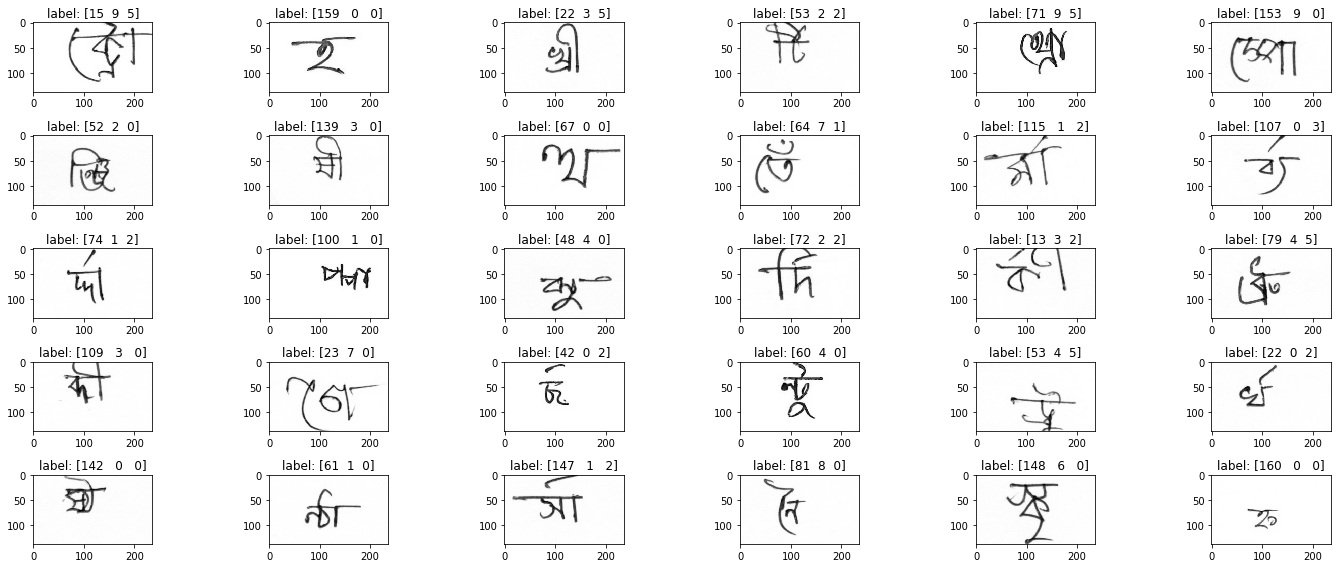

<Figure size 432x288 with 0 Axes>

In [10]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [11]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [12]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


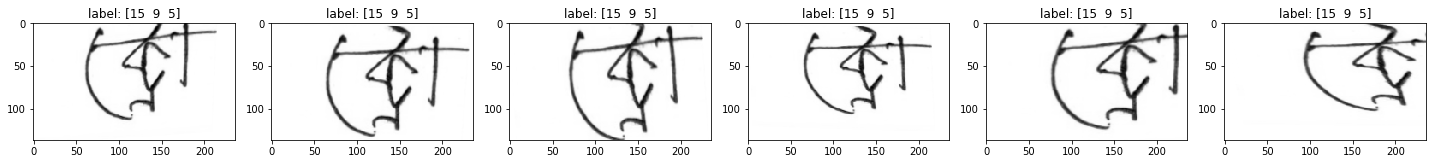

In [13]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

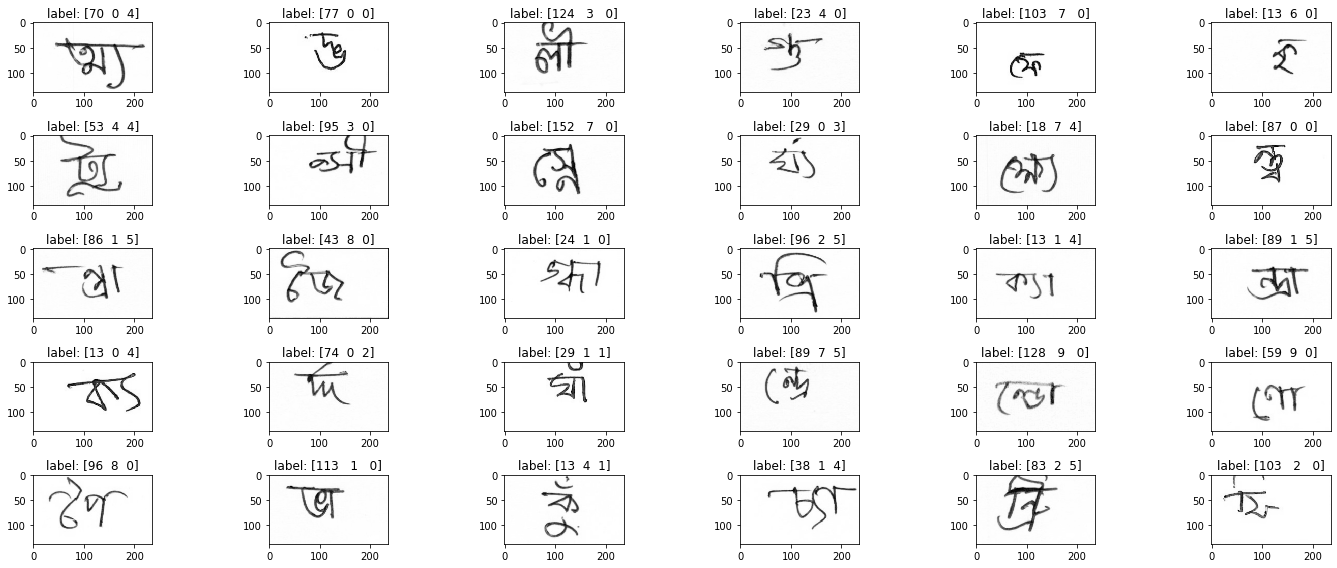

In [14]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

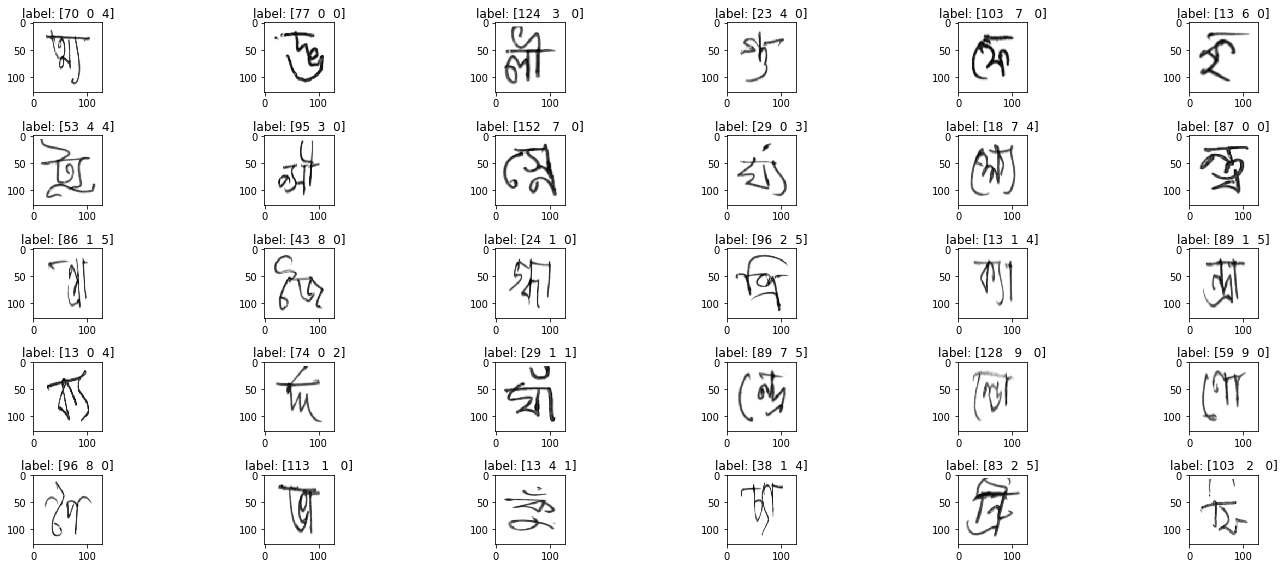

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [16]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.01,#0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [17]:
train_transform = Transform( crop=False,
    size=(128, 128), threshold=40.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0, random_brightness_ratio=0,
    piece_affine_ratio=0.2, ssr_ratio=0.2)

In [18]:
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [19]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image_all = copy.copy(image)
        image = image[0,0]
        #image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        
        
        image_all[:, :, ymin:ymax, xmin:xmax] = self.mask_color
        return image_all

In [20]:
cutout = Cutout(32*2, 1, True, 0)

### Let's final check the processed images, which will be trained by the model.

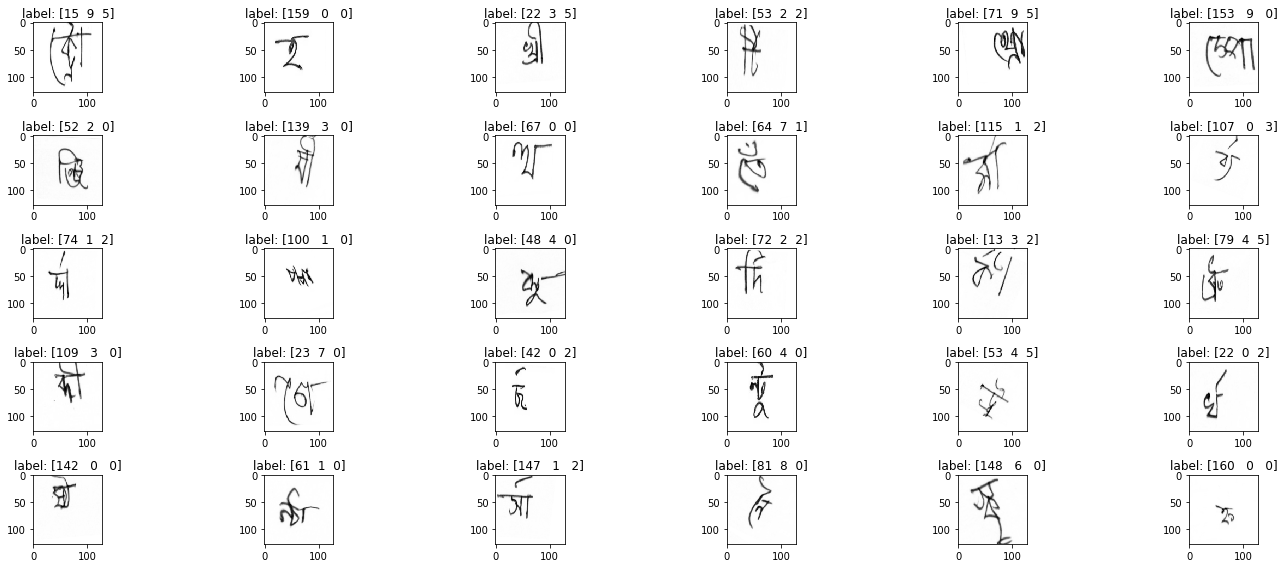

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [22]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [23]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [24]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [25]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [26]:
# GEM
# import torch.nn.functional as F

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [27]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin1_2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers1 = Sequential(lin1_1, lin1_2)
        
        lin2_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2_2 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers2 = Sequential(lin2_1, lin2_2)

        lin3_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin3_2 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers3 = Sequential(lin3_1, lin3_2)

        self.pool = GeM()

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            
            #h1 = torch.sum(h, dim=(-1, -2))
            #h2 = torch.sum(h, dim=(-1, -2))
            #h3 = torch.sum(h, dim=(-1, -2))
            h1 = self.pool(h)[:,:,0,0]
            h2 = self.pool(h)[:,:,0,0]
            h3 = self.pool(h)[:,:,0,0]

            
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h1 = h.view(bs, ch*height*width)
            h2 = h.view(bs, ch*height*width)
            h3 = h.view(bs, ch*height*width)
        for layer in self.lin_layers1:
            h1 = layer(h1)
        for layer in self.lin_layers2:
            h2 = layer(h2)
        for layer in self.lin_layers3:
            h3 = layer(h3)
            
            
        return h1, h2, h3

## Classifier

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        else:
            # cutout
            x = cutout(x)
        
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [30]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(128, 128)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [31]:
pretrainedmodels

<module 'pretrainedmodels' from 'C:\\Users\\Rajneesh Tiwari\\.conda\\envs\\Pytorch\\lib\\site-packages\\pretrainedmodels\\__init__.py'>

In [32]:
# #load weights
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [33]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## Ignite utility

pytorch-ignite utility class for training

In [34]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V12_output\starting_70_epochs\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [35]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [36]:
trainer.run(train_loader, max_epochs=70)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 1674, 'train/loss': 9.766869721161992, 'train/loss_grapheme': 3.724451575797661, 'train/loss_vowel': 1.3692199552927964, 'train/loss_consonant': 0.9487466246352543, 'train/acc_grapheme': 0.17482763341298305, 'train/acc_vowel': 0.5102144315013938, 'train/acc_consonant': 0.6856923287534856, 'train/recall': 0.36054528707962175, 'valid/loss': 2.467748581082838, 'valid/loss_grapheme': 0.9268352242813475, 'valid/loss_vowel': 0.34415151897222157, 'valid/loss_consonant': 0.26992661262326706, 'valid/acc_grapheme': 0.7650706046141603, 'valid/acc_vowel': 0.9223249801113765, 'valid/acc_consonant': 0.9292064439140816, 'valid/recall': 0.8585650106626704, 'lr': 0.003, 'elapsed_time': 2263.7096514}
epoch      1 train/loss  9.766870 train/loss_grapheme  3.724452 train/loss_vowel  1.369220 train/loss_consonant  0.948747 train/acc_grapheme  0.174828 train/acc_vowel  0.510214 train/acc_consonant  0.685692 train/recall  0.360545 valid/loss  2.467749 valid/loss_grapheme  0.926835 v

{'epoch': 2, 'iteration': 3348, 'train/loss': 6.97863863702316, 'train/loss_grapheme': 2.6380035589886397, 'train/loss_vowel': 1.0489799629189207, 'train/loss_consonant': 0.6536515466913385, 'train/acc_grapheme': 0.3544809090003987, 'train/acc_vowel': 0.6097265780565511, 'train/acc_consonant': 0.7481892174432501, 'train/recall': 0.4951091597371279, 'valid/loss': 1.6573426202828674, 'valid/loss_grapheme': 0.5945571219295193, 'valid/loss_vowel': 0.2705232409631438, 'valid/loss_consonant': 0.1977051332201764, 'valid/acc_grapheme': 0.8754474940334127, 'valid/acc_vowel': 0.9572991249005564, 'valid/acc_consonant': 0.9604017501988867, 'valid/recall': 0.9164252235941843, 'lr': 0.003, 'elapsed_time': 4529.3932693}
epoch      2 train/loss  6.978639 train/loss_grapheme  2.638004 train/loss_vowel  1.048980 train/loss_consonant  0.653652 train/acc_grapheme  0.354481 train/acc_vowel  0.609727 train/acc_consonant  0.748189 train/recall  0.495109 valid/loss  1.657343 valid/loss_grapheme  0.594557 vali

{'epoch': 3, 'iteration': 5022, 'train/loss': 6.419203136912953, 'train/loss_grapheme': 2.4204435476692776, 'train/loss_vowel': 0.970253014267203, 'train/loss_consonant': 0.608063023621962, 'train/acc_grapheme': 0.39597023098367246, 'train/acc_vowel': 0.6291069295101553, 'train/acc_consonant': 0.7595735015929894, 'train/recall': 0.528001575449428, 'valid/loss': 1.6267433974509593, 'valid/loss_grapheme': 0.5580201379439143, 'valid/loss_vowel': 0.2917065604063093, 'valid/loss_consonant': 0.21899656094343964, 'valid/acc_grapheme': 0.8938792760540974, 'valid/acc_vowel': 0.963051909307875, 'valid/acc_consonant': 0.9609238265712009, 'valid/recall': 0.9284580985542852, 'lr': 0.003, 'elapsed_time': 6793.0328188}
epoch      3 train/loss  6.419203 train/loss_grapheme  2.420444 train/loss_vowel  0.970253 train/loss_consonant  0.608063 train/acc_grapheme  0.395970 train/acc_vowel  0.629107 train/acc_consonant  0.759574 train/recall  0.528002 valid/loss  1.626743 valid/loss_grapheme  0.558020 valid

{'epoch': 4, 'iteration': 6696, 'train/loss': 6.099378213660264, 'train/loss_grapheme': 2.2935065318927115, 'train/loss_vowel': 0.9270397981933653, 'train/loss_consonant': 0.585325336486564, 'train/acc_grapheme': 0.4035338261648743, 'train/acc_vowel': 0.6239981581043409, 'train/acc_consonant': 0.7556408054559953, 'train/recall': 0.5273289907143006, 'valid/loss': 1.6492050072458309, 'valid/loss_grapheme': 0.5541537566230519, 'valid/loss_vowel': 0.3280929202182765, 'valid/loss_consonant': 0.2128045768043591, 'valid/acc_grapheme': 0.90102923627685, 'valid/acc_vowel': 0.9676014319809065, 'valid/acc_consonant': 0.9694610182975348, 'valid/recall': 0.938108517722883, 'lr': 0.003, 'elapsed_time': 9060.3413164}
epoch      4 train/loss  6.099378 train/loss_grapheme  2.293507 train/loss_vowel  0.927040 train/loss_consonant  0.585325 train/acc_grapheme  0.403534 train/acc_vowel  0.623998 train/acc_consonant  0.755641 train/recall  0.527329 valid/loss  1.649205 valid/loss_grapheme  0.554154 valid/l

{'epoch': 5, 'iteration': 8370, 'train/loss': 5.987657771529262, 'train/loss_grapheme': 2.2392256332554696, 'train/loss_vowel': 0.9250176947479322, 'train/loss_consonant': 0.5841888147834666, 'train/acc_grapheme': 0.4218065511748299, 'train/acc_vowel': 0.6308928215850249, 'train/acc_consonant': 0.7597228444842683, 'train/recall': 0.5423358312816404, 'valid/loss': 1.3279984536489609, 'valid/loss_grapheme': 0.4383162362478798, 'valid/loss_vowel': 0.2696930530318781, 'valid/loss_consonant': 0.18167292822801412, 'valid/acc_grapheme': 0.931404136833732, 'valid/acc_vowel': 0.9754922434367533, 'valid/acc_consonant': 0.9744828957836118, 'valid/recall': 0.9475062336845328, 'lr': 0.003, 'elapsed_time': 11323.2135358}
epoch      5 train/loss  5.987658 train/loss_grapheme  2.239226 train/loss_vowel  0.925018 train/loss_consonant  0.584189 train/acc_grapheme  0.421807 train/acc_vowel  0.630893 train/acc_consonant  0.759723 train/recall  0.542336 valid/loss  1.327998 valid/loss_grapheme  0.438316 va

{'epoch': 6, 'iteration': 10044, 'train/loss': 5.745499830234578, 'train/loss_grapheme': 2.154924768772034, 'train/loss_vowel': 0.8786732273814998, 'train/loss_consonant': 0.5569770614590981, 'train/acc_grapheme': 0.43915210573476676, 'train/acc_vowel': 0.6494486758263649, 'train/acc_consonant': 0.7714835971724417, 'train/recall': 0.5630173581835167, 'valid/loss': 0.9336377932803444, 'valid/loss_grapheme': 0.3093320224478592, 'valid/loss_vowel': 0.17251824985896203, 'valid/loss_consonant': 0.14245549909468197, 'valid/acc_grapheme': 0.9286048130469382, 'valid/acc_vowel': 0.9773369132856005, 'valid/acc_consonant': 0.9755021877486081, 'valid/recall': 0.9501103578623533, 'lr': 0.003, 'elapsed_time': 13586.023949999999}
epoch      6 train/loss  5.745500 train/loss_grapheme  2.154925 train/loss_vowel  0.878673 train/loss_consonant  0.556977 train/acc_grapheme  0.439152 train/acc_vowel  0.649449 train/acc_consonant  0.771484 train/recall  0.563017 valid/loss  0.933638 valid/loss_grapheme  0.3

{'epoch': 7, 'iteration': 11718, 'train/loss': 5.651557668099978, 'train/loss_grapheme': 2.113069948276311, 'train/loss_vowel': 0.8678108333090372, 'train/loss_consonant': 0.557606938033584, 'train/acc_grapheme': 0.44407419852648355, 'train/acc_vowel': 0.6491562126642765, 'train/acc_consonant': 0.7696977050975706, 'train/recall': 0.5645992802981168, 'valid/loss': 0.995480712387613, 'valid/loss_grapheme': 0.3273856485515904, 'valid/loss_vowel': 0.19382183356899635, 'valid/loss_consonant': 0.1468875789770363, 'valid/acc_grapheme': 0.9344570405727928, 'valid/acc_vowel': 0.9791865552903736, 'valid/acc_consonant': 0.9771579156722353, 'valid/recall': 0.9553105363263078, 'lr': 0.003, 'elapsed_time': 15847.8066573}
epoch      7 train/loss  5.651558 train/loss_grapheme  2.113070 train/loss_vowel  0.867811 train/loss_consonant  0.557607 train/acc_grapheme  0.444074 train/acc_vowel  0.649156 train/acc_consonant  0.769698 train/recall  0.564599 valid/loss  0.995481 valid/loss_grapheme  0.327386 va

{'epoch': 8, 'iteration': 13392, 'train/loss': 5.432251065399769, 'train/loss_grapheme': 2.02743268912055, 'train/loss_vowel': 0.8401963797663845, 'train/loss_consonant': 0.5371893105211722, 'train/acc_grapheme': 0.45451575567503, 'train/acc_vowel': 0.6494300079649531, 'train/acc_consonant': 0.7687331989247321, 'train/recall': 0.5676496767083712, 'valid/loss': 1.0026181717192073, 'valid/loss_grapheme': 0.3284229418542903, 'valid/loss_vowel': 0.19231390163551368, 'valid/loss_consonant': 0.15345838676631307, 'valid/acc_grapheme': 0.9353818615751787, 'valid/acc_vowel': 0.9806036197295147, 'valid/acc_consonant': 0.9781125696101824, 'valid/recall': 0.9608643753557542, 'lr': 0.003, 'elapsed_time': 18110.3436402}
epoch      8 train/loss  5.432251 train/loss_grapheme  2.027433 train/loss_vowel  0.840196 train/loss_consonant  0.537189 train/acc_grapheme  0.454516 train/acc_vowel  0.649430 train/acc_consonant  0.768733 train/recall  0.567650 valid/loss  1.002618 valid/loss_grapheme  0.328423 val

{'epoch': 9, 'iteration': 15066, 'train/loss': 5.297628978710163, 'train/loss_grapheme': 1.9831782156154247, 'train/loss_vowel': 0.8092442076150306, 'train/loss_consonant': 0.5220283348082143, 'train/acc_grapheme': 0.4633083183990437, 'train/acc_vowel': 0.662295275786539, 'train/acc_consonant': 0.7771026234567903, 'train/recall': 0.5827002976666892, 'valid/loss': 1.0567156191657436, 'valid/loss_grapheme': 0.33922850015197564, 'valid/loss_vowel': 0.22543652942470832, 'valid/loss_consonant': 0.15282209105522934, 'valid/acc_grapheme': 0.934869729514717, 'valid/acc_vowel': 0.978823587907717, 'valid/acc_consonant': 0.9726829753381069, 'valid/recall': 0.9557002194112019, 'lr': 0.003, 'elapsed_time': 20374.661794300002}
epoch      9 train/loss  5.297629 train/loss_grapheme  1.983178 train/loss_vowel  0.809244 train/loss_consonant  0.522028 train/acc_grapheme  0.463308 train/acc_vowel  0.662295 train/acc_consonant  0.777103 train/recall  0.582700 valid/loss  1.056716 valid/loss_grapheme  0.339

{'epoch': 10, 'iteration': 16740, 'train/loss': 5.328568196175631, 'train/loss_grapheme': 1.9915097414592688, 'train/loss_vowel': 0.8196852120838997, 'train/loss_consonant': 0.5258635120330604, 'train/acc_grapheme': 0.47089058144165596, 'train/acc_vowel': 0.6667102250099569, 'train/acc_consonant': 0.7835305904022298, 'train/recall': 0.5892104197903303, 'valid/loss': 0.8095363180790994, 'valid/loss_grapheme': 0.2777813095466049, 'valid/loss_vowel': 0.13701373857928348, 'valid/loss_consonant': 0.11695996066444245, 'valid/acc_grapheme': 0.9416467780429596, 'valid/acc_vowel': 0.9824035401750201, 'valid/acc_consonant': 0.9772673031026253, 'valid/recall': 0.9568317119643455, 'lr': 0.003, 'elapsed_time': 22634.812161600003}
epoch     10 train/loss  5.328568 train/loss_grapheme  1.991510 train/loss_vowel  0.819685 train/loss_consonant  0.525864 train/acc_grapheme  0.470891 train/acc_vowel  0.666710 train/acc_consonant  0.783531 train/recall  0.589210 valid/loss  0.809536 valid/loss_grapheme  0

{'epoch': 11, 'iteration': 18414, 'train/loss': 5.2464952087530525, 'train/loss_grapheme': 1.9565523225578214, 'train/loss_vowel': 0.8089374220677459, 'train/loss_consonant': 0.5244531393264784, 'train/acc_grapheme': 0.46787572182397436, 'train/acc_vowel': 0.663527354639586, 'train/acc_consonant': 0.7785836071286338, 'train/recall': 0.583141239053971, 'valid/loss': 0.8146250178250607, 'valid/loss_grapheme': 0.2719966888356607, 'valid/loss_vowel': 0.14310342021873287, 'valid/loss_consonant': 0.1275282208063153, 'valid/acc_grapheme': 0.9431980906921232, 'valid/acc_vowel': 0.9829405330151147, 'valid/acc_consonant': 0.9809466984884634, 'valid/recall': 0.9609729708029757, 'lr': 0.003, 'elapsed_time': 24887.9789926}
epoch     11 train/loss  5.246495 train/loss_grapheme  1.956552 train/loss_vowel  0.808937 train/loss_consonant  0.524453 train/acc_grapheme  0.467876 train/acc_vowel  0.663527 train/acc_consonant  0.778584 train/recall  0.583141 valid/loss  0.814625 valid/loss_grapheme  0.271997

{'epoch': 12, 'iteration': 20088, 'train/loss': 5.122941459307676, 'train/loss_grapheme': 1.9104985171570714, 'train/loss_vowel': 0.7905155759852206, 'train/loss_consonant': 0.511428848981608, 'train/acc_grapheme': 0.4800222769812825, 'train/acc_vowel': 0.6712434040223019, 'train/acc_consonant': 0.78396306252489, 'train/recall': 0.594260892365899, 'valid/loss': 0.8835938131894587, 'valid/loss_grapheme': 0.2864182370943784, 'valid/loss_vowel': 0.1821265683324923, 'valid/loss_consonant': 0.1286307701881006, 'valid/acc_grapheme': 0.9429594272076367, 'valid/acc_vowel': 0.9820952665075581, 'valid/acc_consonant': 0.980857199681782, 'valid/recall': 0.9580142145850661, 'lr': 0.003, 'elapsed_time': 27145.766440800002}
epoch     12 train/loss  5.122941 train/loss_grapheme  1.910499 train/loss_vowel  0.790516 train/loss_consonant  0.511429 train/acc_grapheme  0.480022 train/acc_vowel  0.671243 train/acc_consonant  0.783963 train/recall  0.594261 valid/loss  0.883594 valid/loss_grapheme  0.286418 

{'epoch': 13, 'iteration': 21762, 'train/loss': 5.160036190970397, 'train/loss_grapheme': 1.9246169333941479, 'train/loss_vowel': 0.7961581887470351, 'train/loss_consonant': 0.5146441397834636, 'train/acc_grapheme': 0.4780248158104339, 'train/acc_vowel': 0.6739035742731981, 'train/acc_consonant': 0.7861409796893656, 'train/recall': 0.5965626674561799, 'valid/loss': 0.695456408799975, 'valid/loss_grapheme': 0.23332385989106072, 'valid/loss_vowel': 0.12259270432171787, 'valid/loss_consonant': 0.10621598558522637, 'valid/acc_grapheme': 0.9500198886237068, 'valid/acc_vowel': 0.9830996420047728, 'valid/acc_consonant': 0.9822295147175811, 'valid/recall': 0.9660535416541739, 'lr': 0.003, 'elapsed_time': 29407.5657116}
epoch     13 train/loss  5.160036 train/loss_grapheme  1.924617 train/loss_vowel  0.796158 train/loss_consonant  0.514644 train/acc_grapheme  0.478025 train/acc_vowel  0.673904 train/acc_consonant  0.786141 train/recall  0.596563 valid/loss  0.695456 valid/loss_grapheme  0.23332

{'epoch': 14, 'iteration': 23436, 'train/loss': 5.0696426811611355, 'train/loss_grapheme': 1.8908058032215425, 'train/loss_vowel': 0.7820215106384302, 'train/loss_consonant': 0.5060095627933492, 'train/acc_grapheme': 0.4778381371963362, 'train/acc_vowel': 0.6723790322580641, 'train/acc_consonant': 0.7821336121067299, 'train/recall': 0.593349598618319, 'valid/loss': 0.8479108057898382, 'valid/loss_grapheme': 0.2731982568781245, 'valid/loss_vowel': 0.17836654356954207, 'valid/loss_consonant': 0.12314774954873793, 'valid/acc_grapheme': 0.9481056085918869, 'valid/acc_vowel': 0.9831493635640409, 'valid/acc_consonant': 0.9827118138424815, 'valid/recall': 0.9646115724591466, 'lr': 0.003, 'elapsed_time': 31670.147979100002}
epoch     14 train/loss  5.069643 train/loss_grapheme  1.890806 train/loss_vowel  0.782022 train/loss_consonant  0.506010 train/acc_grapheme  0.477838 train/acc_vowel  0.672379 train/acc_consonant  0.782134 train/recall  0.593350 valid/loss  0.847911 valid/loss_grapheme  0.

{'epoch': 15, 'iteration': 25110, 'train/loss': 4.994698649381366, 'train/loss_grapheme': 1.855729499758358, 'train/loss_vowel': 0.777632890605193, 'train/loss_consonant': 0.5056067584093611, 'train/acc_grapheme': 0.47620781063321405, 'train/acc_vowel': 0.6612032058940661, 'train/acc_consonant': 0.7776097670250913, 'train/recall': 0.5840548556149271, 'valid/loss': 0.7488569849146295, 'valid/loss_grapheme': 0.2380868510158648, 'valid/loss_vowel': 0.147500967762493, 'valid/loss_consonant': 0.12518231718309739, 'valid/acc_grapheme': 0.9501342482100241, 'valid/acc_vowel': 0.9848995624502769, 'valid/acc_consonant': 0.9819510739856798, 'valid/recall': 0.9647102557066723, 'lr': 0.003, 'elapsed_time': 33928.7850912}
epoch     15 train/loss  4.994699 train/loss_grapheme  1.855729 train/loss_vowel  0.777633 train/loss_consonant  0.505607 train/acc_grapheme  0.476208 train/acc_vowel  0.661203 train/acc_consonant  0.777610 train/recall  0.584055 valid/loss  0.748857 valid/loss_grapheme  0.238087 v

{'epoch': 16, 'iteration': 26784, 'train/loss': 5.066270738056769, 'train/loss_grapheme': 1.8807295650653229, 'train/loss_vowel': 0.7913866442012887, 'train/loss_consonant': 0.5134249682646143, 'train/acc_grapheme': 0.47763590203106354, 'train/acc_vowel': 0.6640842791716446, 'train/acc_consonant': 0.7785120469932282, 'train/recall': 0.5890726523547475, 'valid/loss': 0.6992128186976995, 'valid/loss_grapheme': 0.24036556727704114, 'valid/loss_vowel': 0.11217486383593453, 'valid/loss_consonant': 0.10630681882290112, 'valid/acc_grapheme': 0.9433174224343678, 'valid/acc_vowel': 0.9811455847255381, 'valid/acc_consonant': 0.9777147971360386, 'valid/recall': 0.9624529006219527, 'lr': 0.003, 'elapsed_time': 36190.4200193}
epoch     16 train/loss  5.066271 train/loss_grapheme  1.880730 train/loss_vowel  0.791387 train/loss_consonant  0.513425 train/acc_grapheme  0.477636 train/acc_vowel  0.664084 train/acc_consonant  0.778512 train/recall  0.589073 valid/loss  0.699213 valid/loss_grapheme  0.240

{'epoch': 17, 'iteration': 28458, 'train/loss': 4.909254539148212, 'train/loss_grapheme': 1.8243182800630087, 'train/loss_vowel': 0.7615548456165597, 'train/loss_consonant': 0.49906313706416383, 'train/acc_grapheme': 0.48551685085623353, 'train/acc_vowel': 0.6725657108721627, 'train/acc_consonant': 0.7816202459179613, 'train/recall': 0.5967466278721384, 'valid/loss': 0.7141868783636708, 'valid/loss_grapheme': 0.23240712137452743, 'valid/loss_vowel': 0.13757123833695573, 'valid/loss_consonant': 0.11180139989158704, 'valid/acc_grapheme': 0.9515264518695307, 'valid/acc_vowel': 0.9840692124105005, 'valid/acc_consonant': 0.9836565234685761, 'valid/recall': 0.9663063712785263, 'lr': 0.003, 'elapsed_time': 38447.843770199994}
epoch     17 train/loss  4.909255 train/loss_grapheme  1.824318 train/loss_vowel  0.761555 train/loss_consonant  0.499063 train/acc_grapheme  0.485517 train/acc_vowel  0.672566 train/acc_consonant  0.781620 train/recall  0.596747 valid/loss  0.714187 valid/loss_grapheme 

{'epoch': 18, 'iteration': 30132, 'train/loss': 4.931950482345112, 'train/loss_grapheme': 1.8331746167927232, 'train/loss_vowel': 0.765503962514221, 'train/loss_consonant': 0.5000972823376724, 'train/acc_grapheme': 0.4886250497809634, 'train/acc_vowel': 0.6771797839506177, 'train/acc_consonant': 0.7841372958980486, 'train/recall': 0.5987255509704245, 'valid/loss': 0.6595687016240168, 'valid/loss_grapheme': 0.22465384155867493, 'valid/loss_vowel': 0.1143217519779194, 'valid/loss_consonant': 0.09593926682214748, 'valid/acc_grapheme': 0.9521579156722353, 'valid/acc_vowel': 0.9858343277645174, 'valid/acc_consonant': 0.9829107000795543, 'valid/recall': 0.968341068779194, 'lr': 0.003, 'elapsed_time': 40712.0368465}
epoch     18 train/loss  4.931950 train/loss_grapheme  1.833175 train/loss_vowel  0.765504 train/loss_consonant  0.500097 train/acc_grapheme  0.488625 train/acc_vowel  0.677180 train/acc_consonant  0.784137 train/recall  0.598726 valid/loss  0.659569 valid/loss_grapheme  0.224654 

{'epoch': 19, 'iteration': 31806, 'train/loss': 4.8231998709794865, 'train/loss_grapheme': 1.7865494866471565, 'train/loss_vowel': 0.7544607592205848, 'train/loss_consonant': 0.4956401366041695, 'train/acc_grapheme': 0.4869449422540816, 'train/acc_vowel': 0.6698775388291527, 'train/acc_consonant': 0.7786209428514523, 'train/recall': 0.5932944623537711, 'valid/loss': 0.610951105848417, 'valid/loss_grapheme': 0.20293478481026994, 'valid/loss_vowel': 0.10990490298495942, 'valid/loss_consonant': 0.09517663213155435, 'valid/acc_grapheme': 0.9535998408910111, 'valid/acc_vowel': 0.9868536197295145, 'valid/acc_consonant': 0.9848001193317407, 'valid/recall': 0.9685514205042739, 'lr': 0.003, 'elapsed_time': 42973.996019}
epoch     19 train/loss  4.823200 train/loss_grapheme  1.786549 train/loss_vowel  0.754461 train/loss_consonant  0.495640 train/acc_grapheme  0.486945 train/acc_vowel  0.669878 train/acc_consonant  0.778621 train/recall  0.593294 valid/loss  0.610951 valid/loss_grapheme  0.20293

{'epoch': 20, 'iteration': 33480, 'train/loss': 4.781328647545447, 'train/loss_grapheme': 1.7726494229199496, 'train/loss_vowel': 0.7464905848154707, 'train/loss_consonant': 0.4895392124749177, 'train/acc_grapheme': 0.5116643020708884, 'train/acc_vowel': 0.6904246316208692, 'train/acc_consonant': 0.7941214904420538, 'train/recall': 0.6191164937101576, 'valid/loss': 0.6196946799755096, 'valid/loss_grapheme': 0.21458293470889686, 'valid/loss_vowel': 0.09814109438074517, 'valid/loss_consonant': 0.09238771485222552, 'valid/acc_grapheme': 0.9536595067621321, 'valid/acc_vowel': 0.9852625298329353, 'valid/acc_consonant': 0.9835570803500393, 'valid/recall': 0.9673336275435007, 'lr': 0.003, 'elapsed_time': 45233.501243299994}
epoch     20 train/loss  4.781329 train/loss_grapheme  1.772649 train/loss_vowel  0.746491 train/loss_consonant  0.489539 train/acc_grapheme  0.511664 train/acc_vowel  0.690425 train/acc_consonant  0.794121 train/recall  0.619116 valid/loss  0.619695 valid/loss_grapheme  0

{'epoch': 21, 'iteration': 35154, 'train/loss': 4.792283400020861, 'train/loss_grapheme': 1.7796414533770213, 'train/loss_vowel': 0.7454672476617239, 'train/loss_consonant': 0.4875332530979579, 'train/acc_grapheme': 0.4933106829948228, 'train/acc_vowel': 0.6782220728793309, 'train/acc_consonant': 0.7868845828355245, 'train/recall': 0.6017280245927444, 'valid/loss': 0.9018255550423214, 'valid/loss_grapheme': 0.293397033840489, 'valid/loss_vowel': 0.18255952004174344, 'valid/loss_consonant': 0.13247196520356402, 'valid/acc_grapheme': 0.95403739061257, 'valid/acc_vowel': 0.9856105807478114, 'valid/acc_consonant': 0.9838554097056479, 'valid/recall': 0.9683139752869454, 'lr': 0.003, 'elapsed_time': 47493.436645099995}
epoch     21 train/loss  4.792283 train/loss_grapheme  1.779641 train/loss_vowel  0.745467 train/loss_consonant  0.487533 train/acc_grapheme  0.493311 train/acc_vowel  0.678222 train/acc_consonant  0.786885 train/recall  0.601728 valid/loss  0.901826 valid/loss_grapheme  0.293

{'epoch': 22, 'iteration': 36828, 'train/loss': 4.820940822273885, 'train/loss_grapheme': 1.7871293166881537, 'train/loss_vowel': 0.7531737632907064, 'train/loss_consonant': 0.4935084215611255, 'train/acc_grapheme': 0.47849773496614895, 'train/acc_vowel': 0.6646132019115889, 'train/acc_consonant': 0.7776066557148534, 'train/recall': 0.5880134102767813, 'valid/loss': 0.8046428189926329, 'valid/loss_grapheme': 0.2683683476257438, 'valid/loss_vowel': 0.1573329064150414, 'valid/loss_consonant': 0.11057321885534004, 'valid/acc_grapheme': 0.9510889021479713, 'valid/acc_vowel': 0.984790175019888, 'valid/acc_consonant': 0.9839051312649152, 'valid/recall': 0.9639191533398983, 'lr': 0.003, 'elapsed_time': 49753.2153517}
epoch     22 train/loss  4.820941 train/loss_grapheme  1.787129 train/loss_vowel  0.753174 train/loss_consonant  0.493508 train/acc_grapheme  0.478498 train/acc_vowel  0.664613 train/acc_consonant  0.777607 train/recall  0.588013 valid/loss  0.804643 valid/loss_grapheme  0.268368

{'epoch': 23, 'iteration': 38502, 'train/loss': 4.678832250951012, 'train/loss_grapheme': 1.7274316111434886, 'train/loss_vowel': 0.73920197431955, 'train/loss_consonant': 0.48476705762247246, 'train/acc_grapheme': 0.5051087714058147, 'train/acc_vowel': 0.6782562972919152, 'train/acc_consonant': 0.7846662186379928, 'train/recall': 0.6065512338623881, 'valid/loss': 0.7016017458319379, 'valid/loss_grapheme': 0.22983121294039247, 'valid/loss_vowel': 0.13877115149699987, 'valid/loss_consonant': 0.10316816947660754, 'valid/acc_grapheme': 0.9554395385839298, 'valid/acc_vowel': 0.9851133651551299, 'valid/acc_consonant': 0.9844520684168648, 'valid/recall': 0.9692480463499071, 'lr': 0.003, 'elapsed_time': 52017.4566346}
epoch     23 train/loss  4.678832 train/loss_grapheme  1.727432 train/loss_vowel  0.739202 train/loss_consonant  0.484767 train/acc_grapheme  0.505109 train/acc_vowel  0.678256 train/acc_consonant  0.784666 train/recall  0.606551 valid/loss  0.701602 valid/loss_grapheme  0.22983

{'epoch': 24, 'iteration': 40176, 'train/loss': 4.684083196104214, 'train/loss_grapheme': 1.7331160218449333, 'train/loss_vowel': 0.7345785751756339, 'train/loss_consonant': 0.4832725659404462, 'train/acc_grapheme': 0.506340850258861, 'train/acc_vowel': 0.6858478942652324, 'train/acc_consonant': 0.7896132019115901, 'train/recall': 0.6138407593991899, 'valid/loss': 0.6193384718781155, 'valid/loss_grapheme': 0.2129014147743405, 'valid/loss_vowel': 0.11104377115540971, 'valid/loss_consonant': 0.08249186885349791, 'valid/acc_grapheme': 0.95740354017502, 'valid/acc_vowel': 0.9865055688146365, 'valid/acc_consonant': 0.9856205250596651, 'valid/recall': 0.9686938139871151, 'lr': 0.003, 'elapsed_time': 54273.447817299995}
epoch     24 train/loss  4.684083 train/loss_grapheme  1.733116 train/loss_vowel  0.734579 train/loss_consonant  0.483273 train/acc_grapheme  0.506341 train/acc_vowel  0.685848 train/acc_consonant  0.789613 train/recall  0.613841 valid/loss  0.619338 valid/loss_grapheme  0.212

{'epoch': 25, 'iteration': 41850, 'train/loss': 4.629754299776386, 'train/loss_grapheme': 1.7133982602858486, 'train/loss_vowel': 0.724754024664187, 'train/loss_consonant': 0.47820375169868823, 'train/acc_grapheme': 0.5072929111907609, 'train/acc_vowel': 0.6885454002389494, 'train/acc_consonant': 0.789529196535244, 'train/recall': 0.6152278848331851, 'valid/loss': 0.5632109234469602, 'valid/loss_grapheme': 0.18753282910741884, 'valid/loss_vowel': 0.10620297080790513, 'valid/loss_consonant': 0.08194229354401761, 'valid/acc_grapheme': 0.9593178202068418, 'valid/acc_vowel': 0.9867790373906122, 'valid/acc_consonant': 0.9859188544152734, 'valid/recall': 0.973080290354671, 'lr': 0.003, 'elapsed_time': 56533.302252299996}
epoch     25 train/loss  4.629754 train/loss_grapheme  1.713398 train/loss_vowel  0.724754 train/loss_consonant  0.478204 train/acc_grapheme  0.507293 train/acc_vowel  0.688545 train/acc_consonant  0.789529 train/recall  0.615228 valid/loss  0.563211 valid/loss_grapheme  0.1

{'epoch': 26, 'iteration': 43524, 'train/loss': 4.602524655213493, 'train/loss_grapheme': 1.699242775830281, 'train/loss_vowel': 0.7257767751292196, 'train/loss_consonant': 0.47826233186637773, 'train/acc_grapheme': 0.517320664078057, 'train/acc_vowel': 0.6898801523297506, 'train/acc_consonant': 0.7932783253683797, 'train/recall': 0.6206544274672113, 'valid/loss': 0.8200344702935731, 'valid/loss_grapheme': 0.2647766117940086, 'valid/loss_vowel': 0.179422294609871, 'valid/loss_consonant': 0.11105895462070274, 'valid/acc_grapheme': 0.9559616149562449, 'valid/acc_vowel': 0.9859834924423228, 'valid/acc_consonant': 0.9853967780429589, 'valid/recall': 0.9736478665245734, 'lr': 0.003, 'elapsed_time': 58795.101269}
epoch     26 train/loss  4.602525 train/loss_grapheme  1.699243 train/loss_vowel  0.725777 train/loss_consonant  0.478262 train/acc_grapheme  0.517321 train/acc_vowel  0.689880 train/acc_consonant  0.793278 train/recall  0.620654 valid/loss  0.820034 valid/loss_grapheme  0.264777 va

{'epoch': 27, 'iteration': 45198, 'train/loss': 4.633793242498253, 'train/loss_grapheme': 1.710199321883874, 'train/loss_vowel': 0.7326100182896447, 'train/loss_consonant': 0.4807845769114036, 'train/acc_grapheme': 0.5109673685782553, 'train/acc_vowel': 0.6851074024293109, 'train/acc_consonant': 0.7897065412186381, 'train/recall': 0.6141721988631628, 'valid/loss': 0.685360743208546, 'valid/loss_grapheme': 0.22311064122613689, 'valid/loss_vowel': 0.14246052973025738, 'valid/loss_consonant': 0.09667893121272397, 'valid/acc_grapheme': 0.9560013922036598, 'valid/acc_vowel': 0.9866398170246611, 'valid/acc_consonant': 0.9862022673031017, 'valid/recall': 0.9715940588463873, 'lr': 0.003, 'elapsed_time': 61047.8697606}
epoch     27 train/loss  4.633793 train/loss_grapheme  1.710199 train/loss_vowel  0.732610 train/loss_consonant  0.480785 train/acc_grapheme  0.510967 train/acc_vowel  0.685107 train/acc_consonant  0.789707 train/recall  0.614172 valid/loss  0.685361 valid/loss_grapheme  0.223111

{'epoch': 28, 'iteration': 46872, 'train/loss': 4.593190110285223, 'train/loss_grapheme': 1.6927842754456732, 'train/loss_vowel': 0.7285743897320122, 'train/loss_consonant': 0.47904716590541807, 'train/acc_grapheme': 0.5222676473516525, 'train/acc_vowel': 0.693193697729989, 'train/acc_consonant': 0.7950455495818398, 'train/recall': 0.6246536082282437, 'valid/loss': 0.6465055715639437, 'valid/loss_grapheme': 0.20799540214436152, 'valid/loss_vowel': 0.1375841903622509, 'valid/loss_consonant': 0.09293057637062448, 'valid/acc_grapheme': 0.9601879474940335, 'valid/acc_vowel': 0.9869779236276836, 'valid/acc_consonant': 0.9860680190930778, 'valid/recall': 0.9705804695304895, 'lr': 0.003, 'elapsed_time': 63312.6147468}
epoch     28 train/loss  4.593190 train/loss_grapheme  1.692784 train/loss_vowel  0.728574 train/loss_consonant  0.479047 train/acc_grapheme  0.522268 train/acc_vowel  0.693194 train/acc_consonant  0.795046 train/recall  0.624654 valid/loss  0.646506 valid/loss_grapheme  0.20799

{'epoch': 29, 'iteration': 48546, 'train/loss': 4.500669946647032, 'train/loss_grapheme': 1.6584276978278103, 'train/loss_vowel': 0.7138866189146235, 'train/loss_consonant': 0.4699279295242744, 'train/acc_grapheme': 0.5067110961768215, 'train/acc_vowel': 0.6781629579848666, 'train/acc_consonant': 0.7851173586220631, 'train/recall': 0.6076398819891625, 'valid/loss': 0.6615177368065054, 'valid/loss_grapheme': 0.21270959033032874, 'valid/loss_vowel': 0.13501721334272468, 'valid/loss_consonant': 0.10108134227855962, 'valid/acc_grapheme': 0.9601133651551319, 'valid/acc_vowel': 0.9858094669848843, 'valid/acc_consonant': 0.9854216388225928, 'valid/recall': 0.9715380364499442, 'lr': 0.003, 'elapsed_time': 65575.571658}
epoch     29 train/loss  4.500670 train/loss_grapheme  1.658428 train/loss_vowel  0.713887 train/loss_consonant  0.469928 train/acc_grapheme  0.506711 train/acc_vowel  0.678163 train/acc_consonant  0.785117 train/recall  0.607640 valid/loss  0.661518 valid/loss_grapheme  0.21271

{'epoch': 30, 'iteration': 50220, 'train/loss': 4.582591374946609, 'train/loss_grapheme': 1.6936684636445882, 'train/loss_vowel': 0.7194920745650428, 'train/loss_consonant': 0.47576236688357243, 'train/acc_grapheme': 0.5179429261250504, 'train/acc_vowel': 0.6933741537236151, 'train/acc_consonant': 0.7937139088012757, 'train/recall': 0.6242523837874314, 'valid/loss': 0.739898188515324, 'valid/loss_grapheme': 0.2430724779895211, 'valid/loss_vowel': 0.15584344326169508, 'valid/loss_consonant': 0.09790978996807749, 'valid/acc_grapheme': 0.954718575974543, 'valid/acc_vowel': 0.9867790373906111, 'valid/acc_consonant': 0.9850984486873512, 'valid/recall': 0.9710402483217337, 'lr': 0.003, 'elapsed_time': 67830.8848558}
epoch     30 train/loss  4.582591 train/loss_grapheme  1.693668 train/loss_vowel  0.719492 train/loss_consonant  0.475762 train/acc_grapheme  0.517943 train/acc_vowel  0.693374 train/acc_consonant  0.793714 train/recall  0.624252 valid/loss  0.739898 valid/loss_grapheme  0.243072

{'epoch': 31, 'iteration': 51894, 'train/loss': 4.532261350248877, 'train/loss_grapheme': 1.6651252489381223, 'train/loss_vowel': 0.7256553387903611, 'train/loss_consonant': 0.47635551520457475, 'train/acc_grapheme': 0.5207462166467544, 'train/acc_vowel': 0.6868808492632423, 'train/acc_consonant': 0.7916448874950224, 'train/recall': 0.6197426552617457, 'valid/loss': 0.7002191969631395, 'valid/loss_grapheme': 0.23154691797025448, 'valid/loss_vowel': 0.13871002476440125, 'valid/loss_consonant': 0.09841533513797496, 'valid/acc_grapheme': 0.9612072394590286, 'valid/acc_vowel': 0.9876243038981699, 'valid/acc_consonant': 0.985123309466984, 'valid/recall': 0.9758349895155453, 'lr': 0.003, 'elapsed_time': 70094.2080835}
epoch     31 train/loss  4.532261 train/loss_grapheme  1.665125 train/loss_vowel  0.725655 train/loss_consonant  0.476356 train/acc_grapheme  0.520746 train/acc_vowel  0.686881 train/acc_consonant  0.791645 train/recall  0.619743 valid/loss  0.700219 valid/loss_grapheme  0.2315

{'epoch': 32, 'iteration': 53568, 'train/loss': 4.5679156793239155, 'train/loss_grapheme': 1.6855611330612585, 'train/loss_vowel': 0.7206130353967563, 'train/loss_consonant': 0.4761803751786906, 'train/acc_grapheme': 0.5104166666666672, 'train/acc_vowel': 0.6845971475507785, 'train/acc_consonant': 0.7898434388689771, 'train/recall': 0.6123437888214829, 'valid/loss': 0.7282206790259459, 'valid/loss_grapheme': 0.23462607764899018, 'valid/loss_vowel': 0.15247299438586953, 'valid/loss_consonant': 0.10649552868416884, 'valid/acc_grapheme': 0.9603122513922027, 'valid/acc_vowel': 0.9882706841686547, 'valid/acc_consonant': 0.9829355608591877, 'valid/recall': 0.9733340123208756, 'lr': 0.003, 'elapsed_time': 72359.6131455}
epoch     32 train/loss  4.567916 train/loss_grapheme  1.685561 train/loss_vowel  0.720613 train/loss_consonant  0.476180 train/acc_grapheme  0.510417 train/acc_vowel  0.684597 train/acc_consonant  0.789843 train/recall  0.612344 valid/loss  0.728221 valid/loss_grapheme  0.234

{'epoch': 33, 'iteration': 55242, 'train/loss': 4.478687020185601, 'train/loss_grapheme': 1.6511845183219391, 'train/loss_vowel': 0.7084453045284841, 'train/loss_consonant': 0.46787268118521147, 'train/acc_grapheme': 0.5184251792114695, 'train/acc_vowel': 0.6897992582636409, 'train/acc_consonant': 0.7917008910792503, 'train/recall': 0.6206026167170178, 'valid/loss': 0.6133521373488169, 'valid/loss_grapheme': 0.20035854975975215, 'valid/loss_vowel': 0.10946104360793257, 'valid/loss_consonant': 0.10317399436363457, 'valid/acc_grapheme': 0.9635938743038975, 'valid/acc_vowel': 0.9881811853619721, 'valid/acc_consonant': 0.9863414876690533, 'valid/recall': 0.9758823197993775, 'lr': 0.003, 'elapsed_time': 74620.84638}
epoch     33 train/loss  4.478687 train/loss_grapheme  1.651185 train/loss_vowel  0.708445 train/loss_consonant  0.467873 train/acc_grapheme  0.518425 train/acc_vowel  0.689799 train/acc_consonant  0.791701 train/recall  0.620603 valid/loss  0.613352 valid/loss_grapheme  0.20035

{'epoch': 34, 'iteration': 56916, 'train/loss': 4.453036592425411, 'train/loss_grapheme': 1.6461379312895674, 'train/loss_vowel': 0.6987215695633434, 'train/loss_consonant': 0.46203915884311053, 'train/acc_grapheme': 0.5119163181999209, 'train/acc_vowel': 0.6870613052568691, 'train/acc_consonant': 0.7907861658701709, 'train/recall': 0.6154064403851668, 'valid/loss': 0.6450709459462997, 'valid/loss_grapheme': 0.21101322674096912, 'valid/loss_vowel': 0.12941984839399562, 'valid/loss_consonant': 0.0936246440259113, 'valid/acc_grapheme': 0.9550815433571997, 'valid/acc_vowel': 0.9859188544152744, 'valid/acc_consonant': 0.9829604216388215, 'valid/recall': 0.9672705243981645, 'lr': 0.003, 'elapsed_time': 76884.5900195}
epoch     34 train/loss  4.453037 train/loss_grapheme  1.646138 train/loss_vowel  0.698722 train/loss_consonant  0.462039 train/acc_grapheme  0.511916 train/acc_vowel  0.687061 train/acc_consonant  0.790786 train/recall  0.615406 valid/loss  0.645071 valid/loss_grapheme  0.2110

{'epoch': 35, 'iteration': 58590, 'train/loss': 4.471051792802207, 'train/loss_grapheme': 1.644798486107424, 'train/loss_vowel': 0.7102440655311589, 'train/loss_consonant': 0.4712107509214391, 'train/acc_grapheme': 0.5187020858223821, 'train/acc_vowel': 0.6872386499402624, 'train/acc_consonant': 0.7901203454798884, 'train/recall': 0.6177324847451948, 'valid/loss': 0.5038676060967343, 'valid/loss_grapheme': 0.1748242708887718, 'valid/loss_vowel': 0.07853739207214842, 'valid/loss_consonant': 0.07568167283384214, 'valid/acc_grapheme': 0.9616050119331738, 'valid/acc_vowel': 0.9873756961018285, 'valid/acc_consonant': 0.9856205250596648, 'valid/recall': 0.9730166249667053, 'lr': 0.003, 'elapsed_time': 79149.7347171}
epoch     35 train/loss  4.471052 train/loss_grapheme  1.644798 train/loss_vowel  0.710244 train/loss_consonant  0.471211 train/acc_grapheme  0.518702 train/acc_vowel  0.687239 train/acc_consonant  0.790120 train/recall  0.617732 valid/loss  0.503868 valid/loss_grapheme  0.174824

{'epoch': 36, 'iteration': 60264, 'train/loss': 4.491373602919539, 'train/loss_grapheme': 1.6501410925224549, 'train/loss_vowel': 0.7185116034566359, 'train/loss_consonant': 0.4725798206957972, 'train/acc_grapheme': 0.5216951662684189, 'train/acc_vowel': 0.6876306750298693, 'train/acc_consonant': 0.7915391029470338, 'train/recall': 0.6181332018165617, 'valid/loss': 0.6020900149049508, 'valid/loss_grapheme': 0.2004375971658133, 'valid/loss_vowel': 0.10779221435933238, 'valid/loss_consonant': 0.0934226082411188, 'valid/acc_grapheme': 0.9577267303102619, 'valid/acc_vowel': 0.987659108989657, 'valid/acc_consonant': 0.9853470564836906, 'valid/recall': 0.9731383245334757, 'lr': 0.003, 'elapsed_time': 81412.8180116}
epoch     36 train/loss  4.491374 train/loss_grapheme  1.650141 train/loss_vowel  0.718512 train/loss_consonant  0.472580 train/acc_grapheme  0.521695 train/acc_vowel  0.687631 train/acc_consonant  0.791539 train/recall  0.618133 valid/loss  0.602090 valid/loss_grapheme  0.200438 

{'epoch': 37, 'iteration': 61938, 'train/loss': 4.474563778283491, 'train/loss_grapheme': 1.646803769159488, 'train/loss_vowel': 0.71088301323648, 'train/loss_consonant': 0.470073228997925, 'train/acc_grapheme': 0.5322549532058934, 'train/acc_vowel': 0.701183542413381, 'train/acc_consonant': 0.7996751792114692, 'train/recall': 0.6334314345240559, 'valid/loss': 0.5669190114750783, 'valid/loss_grapheme': 0.18773681814460025, 'valid/loss_vowel': 0.10349899125874469, 'valid/loss_consonant': 0.08794638382044213, 'valid/acc_grapheme': 0.9623756961018297, 'valid/acc_vowel': 0.9876243038981698, 'valid/acc_consonant': 0.9848001193317417, 'valid/recall': 0.9728195947569209, 'lr': 0.003, 'elapsed_time': 83673.788879}
epoch     37 train/loss  4.474564 train/loss_grapheme  1.646804 train/loss_vowel  0.710883 train/loss_consonant  0.470073 train/acc_grapheme  0.532255 train/acc_vowel  0.701184 train/acc_consonant  0.799675 train/recall  0.633431 valid/loss  0.566919 valid/loss_grapheme  0.187737 val

{'epoch': 38, 'iteration': 63612, 'train/loss': 4.479352194419756, 'train/loss_grapheme': 1.6527023648213386, 'train/loss_vowel': 0.7075698251013723, 'train/loss_consonant': 0.46637764501217377, 'train/acc_grapheme': 0.5126941457586632, 'train/acc_vowel': 0.6873693249701331, 'train/acc_consonant': 0.791199970131423, 'train/recall': 0.6156193536609281, 'valid/loss': 0.5318312639268316, 'valid/loss_grapheme': 0.18362297315088263, 'valid/loss_vowel': 0.09146823186365119, 'valid/loss_consonant': 0.07311708562805146, 'valid/acc_grapheme': 0.9606851630867138, 'valid/acc_vowel': 0.986779037390612, 'valid/acc_consonant': 0.9863166268894181, 'valid/recall': 0.9700746034307288, 'lr': 0.003, 'elapsed_time': 85935.0883246}
epoch     38 train/loss  4.479352 train/loss_grapheme  1.652702 train/loss_vowel  0.707570 train/loss_consonant  0.466378 train/acc_grapheme  0.512694 train/acc_vowel  0.687369 train/acc_consonant  0.791200 train/recall  0.615619 valid/loss  0.531831 valid/loss_grapheme  0.18362

{'epoch': 39, 'iteration': 65286, 'train/loss': 4.471263944265948, 'train/loss_grapheme': 1.6480819906064685, 'train/loss_vowel': 0.7092899671013566, 'train/loss_consonant': 0.46581000128812117, 'train/acc_grapheme': 0.5218102847471131, 'train/acc_vowel': 0.6928047839506168, 'train/acc_consonant': 0.7973199173636012, 'train/recall': 0.6268256594507002, 'valid/loss': 0.5198699953590202, 'valid/loss_grapheme': 0.1744104754668716, 'valid/loss_vowel': 0.0956576563560166, 'valid/loss_consonant': 0.0753913880870422, 'valid/acc_grapheme': 0.9639916467780438, 'valid/acc_vowel': 0.9884049323786788, 'valid/acc_consonant': 0.9864260143198084, 'valid/recall': 0.9732195352077545, 'lr': 0.003, 'elapsed_time': 88195.18377019999}
epoch     39 train/loss  4.471264 train/loss_grapheme  1.648082 train/loss_vowel  0.709290 train/loss_consonant  0.465810 train/acc_grapheme  0.521810 train/acc_vowel  0.692805 train/acc_consonant  0.797320 train/recall  0.626826 valid/loss  0.519870 valid/loss_grapheme  0.17

{'epoch': 40, 'iteration': 66960, 'train/loss': 4.356360398384263, 'train/loss_grapheme': 1.6003830088046573, 'train/loss_vowel': 0.6945870046992313, 'train/loss_consonant': 0.4610073736990082, 'train/acc_grapheme': 0.5180238201911591, 'train/acc_vowel': 0.6841273397052956, 'train/acc_consonant': 0.7869188072481084, 'train/recall': 0.6151753194071409, 'valid/loss': 0.6552502997308471, 'valid/loss_grapheme': 0.22296415564552982, 'valid/loss_vowel': 0.11534634878000952, 'valid/loss_consonant': 0.09397563901074177, 'valid/acc_grapheme': 0.9570057677008745, 'valid/acc_vowel': 0.9861326571201267, 'valid/acc_consonant': 0.9839299920445508, 'valid/recall': 0.9709501704727005, 'lr': 0.003, 'elapsed_time': 90461.4554791}
epoch     40 train/loss  4.356360 train/loss_grapheme  1.600383 train/loss_vowel  0.694587 train/loss_consonant  0.461007 train/acc_grapheme  0.518024 train/acc_vowel  0.684127 train/acc_consonant  0.786919 train/recall  0.615175 valid/loss  0.655250 valid/loss_grapheme  0.2229

{'epoch': 41, 'iteration': 68634, 'train/loss': 4.306297904398991, 'train/loss_grapheme': 1.5883721183349013, 'train/loss_vowel': 0.6794180907398071, 'train/loss_consonant': 0.4501355801872562, 'train/acc_grapheme': 0.5336332636399844, 'train/acc_vowel': 0.7018898098367177, 'train/acc_consonant': 0.8009508164078046, 'train/recall': 0.6344153430004666, 'valid/loss': 0.6091642773805769, 'valid/loss_grapheme': 0.20028269514974945, 'valid/loss_vowel': 0.11470358034591402, 'valid/loss_consonant': 0.09389530618392766, 'valid/acc_grapheme': 0.9606603023070803, 'valid/acc_vowel': 0.9872613365155118, 'valid/acc_consonant': 0.9857050517104202, 'valid/recall': 0.9709944147556275, 'lr': 0.003, 'elapsed_time': 92720.438534}
epoch     41 train/loss  4.306298 train/loss_grapheme  1.588372 train/loss_vowel  0.679418 train/loss_consonant  0.450136 train/acc_grapheme  0.533633 train/acc_vowel  0.701890 train/acc_consonant  0.800951 train/recall  0.634415 valid/loss  0.609164 valid/loss_grapheme  0.20028

{'epoch': 42, 'iteration': 70308, 'train/loss': 4.3205655491159805, 'train/loss_grapheme': 1.5856883402962767, 'train/loss_vowel': 0.6918997327544534, 'train/loss_consonant': 0.45728913829033235, 'train/acc_grapheme': 0.5234126095181205, 'train/acc_vowel': 0.685838560334529, 'train/acc_consonant': 0.7906430455993636, 'train/recall': 0.6170006175294029, 'valid/loss': 0.5761339672283228, 'valid/loss_grapheme': 0.19319721076610832, 'valid/loss_vowel': 0.1039969911154244, 'valid/loss_consonant': 0.08574255543420878, 'valid/acc_grapheme': 0.9619779236276855, 'valid/acc_vowel': 0.9881712410501184, 'valid/acc_consonant': 0.9849244232299117, 'valid/recall': 0.9734647287195435, 'lr': 0.003, 'elapsed_time': 94978.9737289}
epoch     42 train/loss  4.320566 train/loss_grapheme  1.585688 train/loss_vowel  0.691900 train/loss_consonant  0.457289 train/acc_grapheme  0.523413 train/acc_vowel  0.685839 train/acc_consonant  0.790643 train/recall  0.617001 valid/loss  0.576134 valid/loss_grapheme  0.1931

{'epoch': 43, 'iteration': 71982, 'train/loss': 4.456353085941169, 'train/loss_grapheme': 1.63957690820543, 'train/loss_vowel': 0.70908798276933, 'train/loss_consonant': 0.4681112876066241, 'train/acc_grapheme': 0.5294392174432492, 'train/acc_vowel': 0.6960716596973321, 'train/acc_consonant': 0.7972172441258473, 'train/recall': 0.6276022731389586, 'valid/loss': 0.6030172579043805, 'valid/loss_grapheme': 0.20251601905982078, 'valid/loss_vowel': 0.1036888393695713, 'valid/loss_consonant': 0.09429638181104011, 'valid/acc_grapheme': 0.9608343277645186, 'valid/acc_vowel': 0.9882060461416062, 'valid/acc_consonant': 0.9844122911694508, 'valid/recall': 0.9738197567056592, 'lr': 0.003, 'elapsed_time': 97235.72799649999}
epoch     43 train/loss  4.456353 train/loss_grapheme  1.639577 train/loss_vowel  0.709088 train/loss_consonant  0.468111 train/acc_grapheme  0.529439 train/acc_vowel  0.696072 train/acc_consonant  0.797217 train/recall  0.627602 valid/loss  0.603017 valid/loss_grapheme  0.20251

{'epoch': 44, 'iteration': 73656, 'train/loss': 4.356862131430542, 'train/loss_grapheme': 1.6038276488528884, 'train/loss_vowel': 0.6919493864701, 'train/loss_consonant': 0.4572574432311733, 'train/acc_grapheme': 0.5260167761847864, 'train/acc_vowel': 0.6946902379530075, 'train/acc_consonant': 0.7956864794902437, 'train/recall': 0.6246763682082777, 'valid/loss': 0.5931284983858004, 'valid/loss_grapheme': 0.19656624945507414, 'valid/loss_vowel': 0.11794723557899561, 'valid/loss_consonant': 0.08204876351434746, 'valid/acc_grapheme': 0.9622165871121712, 'valid/acc_vowel': 0.9885540970564829, 'valid/acc_consonant': 0.9867492044550502, 'valid/recall': 0.9737018225257579, 'lr': 0.003, 'elapsed_time': 99493.3404206}
epoch     44 train/loss  4.356862 train/loss_grapheme  1.603828 train/loss_vowel  0.691949 train/loss_consonant  0.457257 train/acc_grapheme  0.526017 train/acc_vowel  0.694690 train/acc_consonant  0.795686 train/recall  0.624676 valid/loss  0.593128 valid/loss_grapheme  0.196566 

{'epoch': 45, 'iteration': 75330, 'train/loss': 4.404654671125372, 'train/loss_grapheme': 1.6173690234087275, 'train/loss_vowel': 0.7056277866520905, 'train/loss_consonant': 0.4642888390845224, 'train/acc_grapheme': 0.5154725457984863, 'train/acc_vowel': 0.682490790521705, 'train/acc_consonant': 0.7901452359617683, 'train/recall': 0.6160447608594931, 'valid/loss': 0.4935491738000747, 'valid/loss_grapheme': 0.17182319627314593, 'valid/loss_vowel': 0.07880302600402536, 'valid/loss_consonant': 0.07109975463628485, 'valid/acc_grapheme': 0.9626143595863165, 'valid/acc_vowel': 0.9885043754972149, 'valid/acc_consonant': 0.9864260143198078, 'valid/recall': 0.9740547993315096, 'lr': 0.003, 'elapsed_time': 101751.471467}
epoch     45 train/loss  4.404655 train/loss_grapheme  1.617369 train/loss_vowel  0.705628 train/loss_consonant  0.464289 train/acc_grapheme  0.515473 train/acc_vowel  0.682491 train/acc_consonant  0.790145 train/recall  0.616045 valid/loss  0.493549 valid/loss_grapheme  0.17182

{'epoch': 46, 'iteration': 77004, 'train/loss': 4.454366953498289, 'train/loss_grapheme': 1.6374561983731486, 'train/loss_vowel': 0.7094216855563303, 'train/loss_consonant': 0.47003286109576303, 'train/acc_grapheme': 0.5253914028275604, 'train/acc_vowel': 0.6966099163679795, 'train/acc_consonant': 0.7967941059338903, 'train/recall': 0.6277605820564485, 'valid/loss': 0.5100927942905904, 'valid/loss_grapheme': 0.18058305759169607, 'valid/loss_vowel': 0.07943696288618667, 'valid/loss_consonant': 0.06948971630102979, 'valid/acc_grapheme': 0.9597901750198884, 'valid/acc_vowel': 0.9879425218774855, 'valid/acc_consonant': 0.9864508750994422, 'valid/recall': 0.9721530933079914, 'lr': 0.003, 'elapsed_time': 104333.67167689999}
epoch     46 train/loss  4.454367 train/loss_grapheme  1.637456 train/loss_vowel  0.709422 train/loss_consonant  0.470033 train/acc_grapheme  0.525391 train/acc_vowel  0.696610 train/acc_consonant  0.796794 train/recall  0.627761 valid/loss  0.510093 valid/loss_grapheme  

{'epoch': 47, 'iteration': 78678, 'train/loss': 4.3858149780167475, 'train/loss_grapheme': 1.6084480505289784, 'train/loss_vowel': 0.7039982091542, 'train/loss_consonant': 0.4649206684788816, 'train/acc_grapheme': 0.5378926473516531, 'train/acc_vowel': 0.7031872262046994, 'train/acc_consonant': 0.7995258363201921, 'train/recall': 0.6375607668256296, 'valid/loss': 0.5533903511441124, 'valid/loss_grapheme': 0.1923615182783268, 'valid/loss_vowel': 0.09213420473092496, 'valid/loss_consonant': 0.0765331106300428, 'valid/acc_grapheme': 0.9607199681782022, 'valid/acc_vowel': 0.9877983293556079, 'valid/acc_consonant': 0.9867889817024655, 'valid/recall': 0.9732328214051482, 'lr': 0.003, 'elapsed_time': 106589.5959406}
epoch     47 train/loss  4.385815 train/loss_grapheme  1.608448 train/loss_vowel  0.703998 train/loss_consonant  0.464921 train/acc_grapheme  0.537893 train/acc_vowel  0.703187 train/acc_consonant  0.799526 train/recall  0.637561 valid/loss  0.553390 valid/loss_grapheme  0.192362 

{'epoch': 48, 'iteration': 80352, 'train/loss': 4.237607670371535, 'train/loss_grapheme': 1.5522548027309893, 'train/loss_vowel': 0.6810911582035136, 'train/loss_consonant': 0.4520069026146774, 'train/acc_grapheme': 0.5423511549183594, 'train/acc_vowel': 0.7039526085225004, 'train/acc_consonant': 0.8001294305057743, 'train/recall': 0.638141716801783, 'valid/loss': 0.501517949070168, 'valid/loss_grapheme': 0.16636035658045714, 'valid/loss_vowel': 0.0933098773025243, 'valid/loss_consonant': 0.07548735992258375, 'valid/acc_grapheme': 0.9658562052505958, 'valid/acc_vowel': 0.9890015910898962, 'valid/acc_consonant': 0.9879673826571193, 'valid/recall': 0.9765825222750664, 'lr': 0.0021, 'elapsed_time': 108844.6856215}
epoch     48 train/loss  4.237608 train/loss_grapheme  1.552255 train/loss_vowel  0.681091 train/loss_consonant  0.452007 train/acc_grapheme  0.542351 train/acc_vowel  0.703953 train/acc_consonant  0.800129 train/recall  0.638142 valid/loss  0.501518 valid/loss_grapheme  0.16636

{'epoch': 49, 'iteration': 82026, 'train/loss': 4.1580538391497255, 'train/loss_grapheme': 1.526958233611202, 'train/loss_vowel': 0.6618349315195813, 'train/loss_consonant': 0.44230244351214903, 'train/acc_grapheme': 0.544214829749103, 'train/acc_vowel': 0.7084888988450818, 'train/acc_consonant': 0.8022731232576661, 'train/recall': 0.6411043426341749, 'valid/loss': 0.5186129290619442, 'valid/loss_grapheme': 0.17843910955728381, 'valid/loss_vowel': 0.09034376450967675, 'valid/loss_consonant': 0.07139094481533638, 'valid/acc_grapheme': 0.967919649960223, 'valid/acc_vowel': 0.9897822195704045, 'valid/acc_consonant': 0.9880668257756556, 'valid/recall': 0.9779177530953296, 'lr': 0.0021, 'elapsed_time': 111101.6192422}
epoch     49 train/loss  4.158054 train/loss_grapheme  1.526958 train/loss_vowel  0.661835 train/loss_consonant  0.442302 train/acc_grapheme  0.544215 train/acc_vowel  0.708489 train/acc_consonant  0.802273 train/recall  0.641104 valid/loss  0.518613 valid/loss_grapheme  0.178

{'epoch': 50, 'iteration': 83700, 'train/loss': 4.172182348466689, 'train/loss_grapheme': 1.52916648108935, 'train/loss_vowel': 0.6692384058696395, 'train/loss_consonant': 0.44461097537452, 'train/acc_grapheme': 0.5450082138590202, 'train/acc_vowel': 0.7041797341696536, 'train/acc_consonant': 0.8019371017522903, 'train/recall': 0.6404828619445875, 'valid/loss': 0.5235023532676242, 'valid/loss_grapheme': 0.1836697814145919, 'valid/loss_vowel': 0.08200587296685057, 'valid/loss_consonant': 0.07415691652915359, 'valid/acc_grapheme': 0.9658661495624511, 'valid/acc_vowel': 0.9896479713603815, 'valid/acc_consonant': 0.987907716785998, 'valid/recall': 0.9746451500027753, 'lr': 0.0021, 'elapsed_time': 113359.9598205}
epoch     50 train/loss  4.172182 train/loss_grapheme  1.529166 train/loss_vowel  0.669238 train/loss_consonant  0.444611 train/acc_grapheme  0.545008 train/acc_vowel  0.704180 train/acc_consonant  0.801937 train/recall  0.640483 valid/loss  0.523502 valid/loss_grapheme  0.183670 v

{'epoch': 51, 'iteration': 85374, 'train/loss': 4.066245744981789, 'train/loss_grapheme': 1.4917410580350114, 'train/loss_vowel': 0.6486891065062143, 'train/loss_consonant': 0.43407451929335383, 'train/acc_grapheme': 0.5447064167662291, 'train/acc_vowel': 0.7050509010354455, 'train/acc_consonant': 0.8024006869772989, 'train/recall': 0.6379335928877713, 'valid/loss': 0.4375113702616999, 'valid/loss_grapheme': 0.1509844744600231, 'valid/loss_vowel': 0.06889405366486752, 'valid/loss_consonant': 0.06664836849474964, 'valid/acc_grapheme': 0.9690383850437554, 'valid/acc_vowel': 0.9903092680986465, 'valid/acc_consonant': 0.9877585521081927, 'valid/recall': 0.9797708794664298, 'lr': 0.0021, 'elapsed_time': 115621.64111489999}
epoch     51 train/loss  4.066246 train/loss_grapheme  1.491741 train/loss_vowel  0.648689 train/loss_consonant  0.434075 train/acc_grapheme  0.544706 train/acc_vowel  0.705051 train/acc_consonant  0.802401 train/recall  0.637934 valid/loss  0.437511 valid/loss_grapheme  

{'epoch': 52, 'iteration': 87048, 'train/loss': 4.083802285925747, 'train/loss_grapheme': 1.4966345860922137, 'train/loss_vowel': 0.6560077065581916, 'train/loss_consonant': 0.4345254083403265, 'train/acc_grapheme': 0.5322767323775397, 'train/acc_vowel': 0.6911651234567908, 'train/acc_consonant': 0.7941650487853442, 'train/recall': 0.6273847714085791, 'valid/loss': 0.49299959564550394, 'valid/loss_grapheme': 0.16520266590511032, 'valid/loss_vowel': 0.08712420804617228, 'valid/loss_consonant': 0.07547005558462018, 'valid/acc_grapheme': 0.9680290373906129, 'valid/acc_vowel': 0.9897474144789178, 'valid/acc_consonant': 0.9877187748607787, 'valid/recall': 0.9771575554944347, 'lr': 0.0021, 'elapsed_time': 117877.2895459}
epoch     52 train/loss  4.083802 train/loss_grapheme  1.496635 train/loss_vowel  0.656008 train/loss_consonant  0.434525 train/acc_grapheme  0.532277 train/acc_vowel  0.691165 train/acc_consonant  0.794165 train/recall  0.627385 valid/loss  0.493000 valid/loss_grapheme  0.1

{'epoch': 53, 'iteration': 88722, 'train/loss': 4.101096196645335, 'train/loss_grapheme': 1.5008038694401724, 'train/loss_vowel': 0.6613323512657355, 'train/loss_consonant': 0.43815611351811046, 'train/acc_grapheme': 0.5573041119076063, 'train/acc_vowel': 0.7157786987256085, 'train/acc_consonant': 0.8098647202309841, 'train/recall': 0.6515960507726904, 'valid/loss': 0.4692533244878978, 'valid/loss_grapheme': 0.1596982099542612, 'valid/loss_vowel': 0.07773958120788481, 'valid/loss_consonant': 0.07211732414499956, 'valid/acc_grapheme': 0.9657667064439138, 'valid/acc_vowel': 0.9898120525059649, 'valid/acc_consonant': 0.9880320206841675, 'valid/recall': 0.9739367217096431, 'lr': 0.0021, 'elapsed_time': 120133.0789998}
epoch     53 train/loss  4.101096 train/loss_grapheme  1.500804 train/loss_vowel  0.661332 train/loss_consonant  0.438156 train/acc_grapheme  0.557304 train/acc_vowel  0.715779 train/acc_consonant  0.809865 train/recall  0.651596 valid/loss  0.469253 valid/loss_grapheme  0.15

{'epoch': 54, 'iteration': 90396, 'train/loss': 4.01239481664473, 'train/loss_grapheme': 1.4653890107401168, 'train/loss_vowel': 0.6484013990239822, 'train/loss_consonant': 0.43321539521698027, 'train/acc_grapheme': 0.5454780217044997, 'train/acc_vowel': 0.6981406810035844, 'train/acc_consonant': 0.7986733373158097, 'train/recall': 0.6376195696518945, 'valid/loss': 0.4302838922329336, 'valid/loss_grapheme': 0.1483374103850425, 'valid/loss_vowel': 0.0707546762037391, 'valid/loss_consonant': 0.06285439408995513, 'valid/acc_grapheme': 0.9680041766109788, 'valid/acc_vowel': 0.987743635640413, 'valid/acc_consonant': 0.9885391805887027, 'valid/recall': 0.9738190349450431, 'lr': 0.0021, 'elapsed_time': 122395.3032191}
epoch     54 train/loss  4.012395 train/loss_grapheme  1.465389 train/loss_vowel  0.648401 train/loss_consonant  0.433215 train/acc_grapheme  0.545478 train/acc_vowel  0.698141 train/acc_consonant  0.798673 train/recall  0.637620 valid/loss  0.430284 valid/loss_grapheme  0.14833

{'epoch': 55, 'iteration': 92070, 'train/loss': 4.006424615139602, 'train/loss_grapheme': 1.462772702034941, 'train/loss_vowel': 0.6468382490055553, 'train/loss_consonant': 0.4340409635095507, 'train/acc_grapheme': 0.5509165919952209, 'train/acc_vowel': 0.7054024790919947, 'train/acc_consonant': 0.8013335075667063, 'train/recall': 0.6420820091386353, 'valid/loss': 0.5630085062155575, 'valid/loss_grapheme': 0.19030159471783262, 'valid/loss_vowel': 0.09428651378376672, 'valid/loss_consonant': 0.08811880272939837, 'valid/acc_grapheme': 0.9603221957040569, 'valid/acc_vowel': 0.9865900954653928, 'valid/acc_consonant': 0.9848846459824974, 'valid/recall': 0.9721260756923752, 'lr': 0.0021, 'elapsed_time': 124650.43181739999}
epoch     55 train/loss  4.006425 train/loss_grapheme  1.462773 train/loss_vowel  0.646838 train/loss_consonant  0.434041 train/acc_grapheme  0.550917 train/acc_vowel  0.705402 train/acc_consonant  0.801334 train/recall  0.642082 valid/loss  0.563009 valid/loss_grapheme  0

{'epoch': 56, 'iteration': 93744, 'train/loss': 4.08957693671525, 'train/loss_grapheme': 1.4957311811568739, 'train/loss_vowel': 0.6589933050064238, 'train/loss_consonant': 0.4391212688253808, 'train/acc_grapheme': 0.543651682596575, 'train/acc_vowel': 0.6998612355635202, 'train/acc_consonant': 0.7996440661091186, 'train/recall': 0.6354094790328609, 'valid/loss': 0.44302174498756064, 'valid/loss_grapheme': 0.14739763982113904, 'valid/loss_vowel': 0.08142260394474772, 'valid/loss_consonant': 0.06680386205846199, 'valid/acc_grapheme': 0.9707140015910903, 'valid/acc_vowel': 0.9908810660302294, 'valid/acc_consonant': 0.9889021479713598, 'valid/recall': 0.9797421936289277, 'lr': 0.0021, 'elapsed_time': 126904.1467531}
epoch     56 train/loss  4.089577 train/loss_grapheme  1.495731 train/loss_vowel  0.658993 train/loss_consonant  0.439121 train/acc_grapheme  0.543652 train/acc_vowel  0.699861 train/acc_consonant  0.799644 train/recall  0.635409 valid/loss  0.443022 valid/loss_grapheme  0.147

{'epoch': 57, 'iteration': 95418, 'train/loss': 4.175728657624485, 'train/loss_grapheme': 1.5256085581231857, 'train/loss_vowel': 0.677898967872277, 'train/loss_consonant': 0.44661256997415455, 'train/acc_grapheme': 0.5491089207487055, 'train/acc_vowel': 0.7062238649940267, 'train/acc_consonant': 0.803551871764237, 'train/recall': 0.6437323387015026, 'valid/loss': 0.3957935522592722, 'valid/loss_grapheme': 0.13702597817614995, 'valid/loss_vowel': 0.06346906108563868, 'valid/loss_consonant': 0.058272534216751916, 'valid/acc_grapheme': 0.9700178997613368, 'valid/acc_vowel': 0.9903689339697687, 'valid/acc_consonant': 0.9895336117740647, 'valid/recall': 0.9796942572735399, 'lr': 0.0021, 'elapsed_time': 129166.7048899}
epoch     57 train/loss  4.175729 train/loss_grapheme  1.525609 train/loss_vowel  0.677899 train/loss_consonant  0.446613 train/acc_grapheme  0.549109 train/acc_vowel  0.706224 train/acc_consonant  0.803552 train/recall  0.643732 valid/loss  0.395794 valid/loss_grapheme  0.13

{'epoch': 58, 'iteration': 97092, 'train/loss': 4.024829380988647, 'train/loss_grapheme': 1.4709990542680202, 'train/loss_vowel': 0.6505217482953409, 'train/loss_consonant': 0.4323095147483487, 'train/acc_grapheme': 0.5356742831541219, 'train/acc_vowel': 0.6907730983671853, 'train/acc_consonant': 0.7933841099163679, 'train/recall': 0.6270225415561435, 'valid/loss': 0.6224857449958319, 'valid/loss_grapheme': 0.2001232569392655, 'valid/loss_vowel': 0.12548146377315383, 'valid/loss_consonant': 0.09675776828658325, 'valid/acc_grapheme': 0.967820206841686, 'valid/acc_vowel': 0.9897722752585509, 'valid/acc_consonant': 0.9882309069212402, 'valid/recall': 0.9782552099661671, 'lr': 0.0021, 'elapsed_time': 131426.7285759}
epoch     58 train/loss  4.024829 train/loss_grapheme  1.470999 train/loss_vowel  0.650522 train/loss_consonant  0.432310 train/acc_grapheme  0.535674 train/acc_vowel  0.690773 train/acc_consonant  0.793384 train/recall  0.627023 valid/loss  0.622486 valid/loss_grapheme  0.2001

{'epoch': 59, 'iteration': 98766, 'train/loss': 4.102448845662737, 'train/loss_grapheme': 1.4995966605049877, 'train/loss_vowel': 0.6651057329467245, 'train/loss_consonant': 0.4381497869515077, 'train/acc_grapheme': 0.5491244772998809, 'train/acc_vowel': 0.7059282905217057, 'train/acc_consonant': 0.8034305306650739, 'train/recall': 0.6396381440759439, 'valid/loss': 0.4868620146857241, 'valid/loss_grapheme': 0.1636567931969012, 'valid/loss_vowel': 0.08589106631912025, 'valid/loss_consonant': 0.07365736281743766, 'valid/acc_grapheme': 0.967994232299125, 'valid/acc_vowel': 0.9901302704852815, 'valid/acc_consonant': 0.9878679395385823, 'valid/recall': 0.9786482841656678, 'lr': 0.0021, 'elapsed_time': 133693.0969576}
epoch     59 train/loss  4.102449 train/loss_grapheme  1.499597 train/loss_vowel  0.665106 train/loss_consonant  0.438150 train/acc_grapheme  0.549124 train/acc_vowel  0.705928 train/acc_consonant  0.803431 train/recall  0.639638 valid/loss  0.486862 valid/loss_grapheme  0.1636

{'epoch': 60, 'iteration': 100440, 'train/loss': 4.058208716812954, 'train/loss_grapheme': 1.4795251290315012, 'train/loss_vowel': 0.6611975297596631, 'train/loss_consonant': 0.4379609268116392, 'train/acc_grapheme': 0.5487791218637994, 'train/acc_vowel': 0.700287485065711, 'train/acc_consonant': 0.8002725507765824, 'train/recall': 0.6383525733492378, 'valid/loss': 0.6042880129273581, 'valid/loss_grapheme': 0.20793364541982978, 'valid/loss_vowel': 0.1044563823568508, 'valid/loss_consonant': 0.08396434062882938, 'valid/acc_grapheme': 0.9669252187748602, 'valid/acc_vowel': 0.9890662291169439, 'valid/acc_consonant': 0.9872613365155134, 'valid/recall': 0.9782455490372062, 'lr': 0.0021, 'elapsed_time': 135957.8855293}
epoch     60 train/loss  4.058209 train/loss_grapheme  1.479525 train/loss_vowel  0.661198 train/loss_consonant  0.437961 train/acc_grapheme  0.548779 train/acc_vowel  0.700287 train/acc_consonant  0.800273 train/recall  0.638353 valid/loss  0.604288 valid/loss_grapheme  0.207

{'epoch': 61, 'iteration': 102114, 'train/loss': 3.9995565874904857, 'train/loss_grapheme': 1.4597341461082656, 'train/loss_vowel': 0.6478199223290101, 'train/loss_consonant': 0.43226837072401275, 'train/acc_grapheme': 0.5635236210673045, 'train/acc_vowel': 0.716914326961371, 'train/acc_consonant': 0.8084086270410215, 'train/recall': 0.6518740210517913, 'valid/loss': 0.44580489717121624, 'valid/loss_grapheme': 0.15484293855211045, 'valid/loss_vowel': 0.07151973569378932, 'valid/loss_consonant': 0.06459928532453312, 'valid/acc_grapheme': 0.9675467382657121, 'valid/acc_vowel': 0.989772275258551, 'valid/acc_consonant': 0.988787788385043, 'valid/recall': 0.9763030954299396, 'lr': 0.0021, 'elapsed_time': 138214.6103845}
epoch     61 train/loss  3.999557 train/loss_grapheme  1.459734 train/loss_vowel  0.647820 train/loss_consonant  0.432268 train/acc_grapheme  0.563524 train/acc_vowel  0.716914 train/acc_consonant  0.808409 train/recall  0.651874 valid/loss  0.445805 valid/loss_grapheme  0.1

{'epoch': 62, 'iteration': 103788, 'train/loss': 4.014906488572612, 'train/loss_grapheme': 1.4687515885981963, 'train/loss_vowel': 0.6464733913620954, 'train/loss_consonant': 0.4309299244315073, 'train/acc_grapheme': 0.5685172739944241, 'train/acc_vowel': 0.7206696784149742, 'train/acc_consonant': 0.8108230037833524, 'train/recall': 0.6587348882998213, 'valid/loss': 0.49366093122873783, 'valid/loss_grapheme': 0.16456253748378208, 'valid/loss_vowel': 0.0886832147854467, 'valid/loss_consonant': 0.07585264068443621, 'valid/acc_grapheme': 0.9674970167064437, 'valid/acc_vowel': 0.989051312649164, 'valid/acc_consonant': 0.9890115354017484, 'valid/recall': 0.9774750510711229, 'lr': 0.0021, 'elapsed_time': 140475.8382624}
epoch     62 train/loss  4.014906 train/loss_grapheme  1.468752 train/loss_vowel  0.646473 train/loss_consonant  0.430930 train/acc_grapheme  0.568517 train/acc_vowel  0.720670 train/acc_consonant  0.810823 train/recall  0.658735 valid/loss  0.493661 valid/loss_grapheme  0.16

{'epoch': 63, 'iteration': 105462, 'train/loss': 4.05663757494416, 'train/loss_grapheme': 1.481116651282551, 'train/loss_vowel': 0.6572847614440902, 'train/loss_consonant': 0.4371195115469476, 'train/acc_grapheme': 0.5542114695340495, 'train/acc_vowel': 0.708787584627638, 'train/acc_consonant': 0.8046843886897638, 'train/recall': 0.6482275180766006, 'valid/loss': 0.44184832691008263, 'valid/loss_grapheme': 0.15298100239052692, 'valid/loss_vowel': 0.07518127902915483, 'valid/loss_consonant': 0.06070504242416498, 'valid/acc_grapheme': 0.9683025059665867, 'valid/acc_vowel': 0.9898816626889418, 'valid/acc_consonant': 0.9879425218774854, 'valid/recall': 0.9776730021236648, 'lr': 0.0021, 'elapsed_time': 142736.9344864}
epoch     63 train/loss  4.056638 train/loss_grapheme  1.481117 train/loss_vowel  0.657285 train/loss_consonant  0.437120 train/acc_grapheme  0.554211 train/acc_vowel  0.708788 train/acc_consonant  0.804684 train/recall  0.648228 valid/loss  0.441848 valid/loss_grapheme  0.152

{'epoch': 64, 'iteration': 107136, 'train/loss': 3.9949970224709777, 'train/loss_grapheme': 1.4620079071914138, 'train/loss_vowel': 0.6436340565300294, 'train/loss_consonant': 0.42734714994471845, 'train/acc_grapheme': 0.5480137395459977, 'train/acc_vowel': 0.7038561579052166, 'train/acc_consonant': 0.8018126493428906, 'train/recall': 0.6405233219868082, 'valid/loss': 0.4962897237416953, 'valid/loss_grapheme': 0.1690363319310624, 'valid/loss_vowel': 0.0827380458519823, 'valid/loss_consonant': 0.07547901443656987, 'valid/acc_grapheme': 0.9686406125696092, 'valid/acc_vowel': 0.9889667859984083, 'valid/acc_consonant': 0.9891507557676998, 'valid/recall': 0.9783512835211793, 'lr': 0.0021, 'elapsed_time': 144999.5218288}
epoch     64 train/loss  3.994997 train/loss_grapheme  1.462008 train/loss_vowel  0.643634 train/loss_consonant  0.427347 train/acc_grapheme  0.548014 train/acc_vowel  0.703856 train/acc_consonant  0.801813 train/recall  0.640523 valid/loss  0.496290 valid/loss_grapheme  0.1

{'epoch': 65, 'iteration': 108810, 'train/loss': 4.02152657386009, 'train/loss_grapheme': 1.4706369475099919, 'train/loss_vowel': 0.6502290645785621, 'train/loss_consonant': 0.43002361382981996, 'train/acc_grapheme': 0.5703093886897649, 'train/acc_vowel': 0.7220853245718831, 'train/acc_consonant': 0.8149828255675031, 'train/recall': 0.6617168794173225, 'valid/loss': 0.4920878882624369, 'valid/loss_grapheme': 0.16695797011291783, 'valid/loss_vowel': 0.0829046052882808, 'valid/loss_consonant': 0.07526734296170226, 'valid/acc_grapheme': 0.9678947891805886, 'valid/acc_vowel': 0.9891358392999192, 'valid/acc_consonant': 0.9877684964200468, 'valid/recall': 0.9776139224253526, 'lr': 0.0021, 'elapsed_time': 147259.8673997}
epoch     65 train/loss  4.021527 train/loss_grapheme  1.470637 train/loss_vowel  0.650229 train/loss_consonant  0.430024 train/acc_grapheme  0.570309 train/acc_vowel  0.722085 train/acc_consonant  0.814983 train/recall  0.661717 valid/loss  0.492088 valid/loss_grapheme  0.16

{'epoch': 66, 'iteration': 110484, 'train/loss': 4.011962886859653, 'train/loss_grapheme': 1.4629160699500228, 'train/loss_vowel': 0.6519997923155376, 'train/loss_consonant': 0.43413095588805856, 'train/acc_grapheme': 0.545453131222621, 'train/acc_vowel': 0.6986664924332935, 'train/acc_consonant': 0.7971239048187979, 'train/recall': 0.6343844021251225, 'valid/loss': 0.4093748775615328, 'valid/loss_grapheme': 0.1424978964012961, 'valid/loss_vowel': 0.06415104540620613, 'valid/loss_consonant': 0.06022803898820729, 'valid/acc_grapheme': 0.9696201272871913, 'valid/acc_vowel': 0.9897474144789179, 'valid/acc_consonant': 0.9887629276054086, 'valid/recall': 0.9786633515210161, 'lr': 0.0021, 'elapsed_time': 149518.15135179998}
epoch     66 train/loss  4.011963 train/loss_grapheme  1.462916 train/loss_vowel  0.652000 train/loss_consonant  0.434131 train/acc_grapheme  0.545453 train/acc_vowel  0.698666 train/acc_consonant  0.797124 train/recall  0.634384 valid/loss  0.409375 valid/loss_grapheme  

{'epoch': 67, 'iteration': 112158, 'train/loss': 4.010121981943807, 'train/loss_grapheme': 1.4627109992394631, 'train/loss_vowel': 0.6514485751399982, 'train/loss_consonant': 0.43325140302735987, 'train/acc_grapheme': 0.5554559936280374, 'train/acc_vowel': 0.7072692652329741, 'train/acc_consonant': 0.804429261250499, 'train/recall': 0.646418359410306, 'valid/loss': 0.5525753207166895, 'valid/loss_grapheme': 0.18831833944542595, 'valid/loss_vowel': 0.09993552116050355, 'valid/loss_consonant': 0.07600311989182504, 'valid/acc_grapheme': 0.968317422434367, 'valid/acc_vowel': 0.9900308273667446, 'valid/acc_consonant': 0.9881414081145576, 'valid/recall': 0.97736182370799, 'lr': 0.0021, 'elapsed_time': 151786.9093502}
epoch     67 train/loss  4.010122 train/loss_grapheme  1.462711 train/loss_vowel  0.651449 train/loss_consonant  0.433251 train/acc_grapheme  0.555456 train/acc_vowel  0.707269 train/acc_consonant  0.804429 train/recall  0.646418 valid/loss  0.552575 valid/loss_grapheme  0.18831

{'epoch': 68, 'iteration': 113832, 'train/loss': 4.005386056919252, 'train/loss_grapheme': 1.4621208897427953, 'train/loss_vowel': 0.6519498421922949, 'train/loss_consonant': 0.4291944365854973, 'train/acc_grapheme': 0.562076861808045, 'train/acc_vowel': 0.7119237853444832, 'train/acc_consonant': 0.809258014735165, 'train/recall': 0.6497661582573288, 'valid/loss': 0.48295946244977256, 'valid/loss_grapheme': 0.16552636390085151, 'valid/loss_vowel': 0.07936299327307499, 'valid/loss_consonant': 0.07254374161504902, 'valid/acc_grapheme': 0.9688394988066829, 'valid/acc_vowel': 0.9896728321400147, 'valid/acc_consonant': 0.9880320206841678, 'valid/recall': 0.9779772928984747, 'lr': 0.0021, 'elapsed_time': 154046.4274498}
epoch     68 train/loss  4.005386 train/loss_grapheme  1.462121 train/loss_vowel  0.651950 train/loss_consonant  0.429194 train/acc_grapheme  0.562077 train/acc_vowel  0.711924 train/acc_consonant  0.809258 train/recall  0.649766 valid/loss  0.482959 valid/loss_grapheme  0.16

{'epoch': 69, 'iteration': 115506, 'train/loss': 3.9956634426433837, 'train/loss_grapheme': 1.4598885005520237, 'train/loss_vowel': 0.6466458514855736, 'train/loss_consonant': 0.42924059225132816, 'train/acc_grapheme': 0.5586326413779366, 'train/acc_vowel': 0.7116002090800468, 'train/acc_consonant': 0.8061529271206698, 'train/recall': 0.6499177597574102, 'valid/loss': 0.4675739012783069, 'valid/loss_grapheme': 0.15943264905229956, 'valid/loss_vowel': 0.08187293738731337, 'valid/loss_consonant': 0.0668356673511941, 'valid/acc_grapheme': 0.9676710421638822, 'valid/acc_vowel': 0.9891408114558461, 'valid/acc_consonant': 0.9887281225139211, 'valid/recall': 0.9779506447917018, 'lr': 0.0021, 'elapsed_time': 156306.5529144}
epoch     69 train/loss  3.995663 train/loss_grapheme  1.459889 train/loss_vowel  0.646646 train/loss_consonant  0.429241 train/acc_grapheme  0.558633 train/acc_vowel  0.711600 train/acc_consonant  0.806153 train/recall  0.649918 valid/loss  0.467574 valid/loss_grapheme  0.

{'epoch': 70, 'iteration': 117180, 'train/loss': 4.058251215423165, 'train/loss_grapheme': 1.4813885307929777, 'train/loss_vowel': 0.6582591682627993, 'train/loss_consonant': 0.43721498666484726, 'train/acc_grapheme': 0.5448277578653922, 'train/acc_vowel': 0.6992514187574677, 'train/acc_consonant': 0.7999831989247328, 'train/recall': 0.6343759746400678, 'valid/loss': 0.3944529488789438, 'valid/loss_grapheme': 0.1383745026794709, 'valid/loss_vowel': 0.06078679021225624, 'valid/loss_consonant': 0.05691715373895476, 'valid/acc_grapheme': 0.9669600238663493, 'valid/acc_vowel': 0.989812052505965, 'valid/acc_consonant': 0.9888027048528231, 'valid/recall': 0.9763204426927721, 'lr': 0.0021, 'elapsed_time': 158568.7864485}
epoch     70 train/loss  4.058251 train/loss_grapheme  1.481389 train/loss_vowel  0.658259 train/loss_consonant  0.437215 train/acc_grapheme  0.544828 train/acc_vowel  0.699251 train/acc_consonant  0.799983 train/recall  0.634376 valid/loss  0.394453 valid/loss_grapheme  0.13

State:
	iteration: 117180
	epoch: 70
	epoch_length: 1674
	max_epochs: 70
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [37]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1674,9.766870,3.724452,1.369220,0.948747,0.174828,0.510214,0.685692,0.360545,2.467749,0.926835,0.344152,0.269927,0.765071,0.922325,0.929206,0.858565,0.0030,2263.709651
1,2,3348,6.978639,2.638004,1.048980,0.653652,0.354481,0.609727,0.748189,0.495109,1.657343,0.594557,0.270523,0.197705,0.875447,0.957299,0.960402,0.916425,0.0030,4529.393269
2,3,5022,6.419203,2.420444,0.970253,0.608063,0.395970,0.629107,0.759574,0.528002,1.626743,0.558020,0.291707,0.218997,0.893879,0.963052,0.960924,0.928458,0.0030,6793.032819
3,4,6696,6.099378,2.293507,0.927040,0.585325,0.403534,0.623998,0.755641,0.527329,1.649205,0.554154,0.328093,0.212805,0.901029,0.967601,0.969461,0.938109,0.0030,9060.341316
4,5,8370,5.987658,2.239226,0.925018,0.584189,0.421807,0.630893,0.759723,0.542336,1.327998,0.438316,0.269693,0.181673,0.931404,0.975492,0.974483,0.947506,0.0030,11323.213536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,110484,4.011963,1.462916,0.652000,0.434131,0.545453,0.698666,0.797124,0.634384,0.409375,0.142498,0.064151,0.060228,0.969620,0.989747,0.988763,0.978663,0.0021,149518.151352
66,67,112158,4.010122,1.462711,0.651449,0.433251,0.555456,0.707269,0.804429,0.646418,0.552575,0.188318,0.099936,0.076003,0.968317,0.990031,0.988141,0.977362,0.0021,151786.909350
67,68,113832,4.005386,1.462121,0.651950,0.429194,0.562077,0.711924,0.809258,0.649766,0.482959,0.165526,0.079363,0.072544,0.968839,0.989673,0.988032,0.977977,0.0021,154046.427450
68,69,115506,3.995663,1.459889,0.646646,0.429241,0.558633,0.711600,0.806153,0.649918,0.467574,0.159433,0.081873,0.066836,0.967671,0.989141,0.988728,0.977951,0.0021,156306.552914


In [38]:
torch.cuda.empty_cache()

### After 70 epochs

In [39]:
# #load weights
predictor.load_state_dict(torch.load(r"C:\Users\Kaggle\BengaliAI\V12_output\starting_70_epochs\models\model_000070.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

In [40]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V12_output\70_to_150_epochs\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [41]:
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V12_output\70_to_150_epochs')
out=r'C:\Users\Kaggle\BengaliAI\V12_output\70_to_150_epochs'

In [42]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [43]:
trainer.run(train_loader, max_epochs=80)

{'epoch': 1, 'iteration': 1674, 'train/loss': 4.256505148563192, 'train/loss_grapheme': 1.5575678303187965, 'train/loss_vowel': 0.686209027037879, 'train/loss_consonant': 0.45516045653932197, 'train/acc_grapheme': 0.5390500547590605, 'train/acc_vowel': 0.7010653126244529, 'train/acc_consonant': 0.7990124701314213, 'train/recall': 0.6323191328886145, 'valid/loss': 0.753284079149401, 'valid/loss_grapheme': 0.25670040665563365, 'valid/loss_vowel': 0.1282887913660104, 'valid/loss_consonant': 0.11159447426763242, 'valid/acc_grapheme': 0.9385988464598243, 'valid/acc_vowel': 0.9716239061256958, 'valid/acc_consonant': 0.975268496420048, 'valid/recall': 0.9497818377041258, 'lr': 0.003, 'elapsed_time': 2239.429078200017}
epoch      1 train/loss  4.256505 train/loss_grapheme  1.557568 train/loss_vowel  0.686209 train/loss_consonant  0.455160 train/acc_grapheme  0.539050 train/acc_vowel  0.701065 train/acc_consonant  0.799012 train/recall  0.632319 valid/loss  0.753284 valid/loss_grapheme  0.25670

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 2, 'iteration': 3348, 'train/loss': 4.208529115987223, 'train/loss_grapheme': 1.5438326409257939, 'train/loss_vowel': 0.6742989419822625, 'train/loss_consonant': 0.4465648913455586, 'train/acc_grapheme': 0.5442241636798086, 'train/acc_vowel': 0.7050851254480293, 'train/acc_consonant': 0.8036732128634008, 'train/recall': 0.64050536978575, 'valid/loss': 0.6277896730598231, 'valid/loss_grapheme': 0.20614341553967439, 'valid/loss_vowel': 0.12141990277533884, 'valid/loss_consonant': 0.09408293879615379, 'valid/acc_grapheme': 0.9638275656324584, 'valid/acc_vowel': 0.9870375894988066, 'valid/acc_consonant': 0.985968575974542, 'valid/recall': 0.9752285869297983, 'lr': 0.003, 'elapsed_time': 4462.611257500015}
epoch      2 train/loss  4.208529 train/loss_grapheme  1.543833 train/loss_vowel  0.674299 train/loss_consonant  0.446565 train/acc_grapheme  0.544224 train/acc_vowel  0.705085 train/acc_consonant  0.803673 train/recall  0.640505 valid/loss  0.627790 valid/loss_grapheme  0.20614

{'epoch': 3, 'iteration': 5022, 'train/loss': 4.23234682805222, 'train/loss_grapheme': 1.5546420232093534, 'train/loss_vowel': 0.6756812548298242, 'train/loss_consonant': 0.44738152066163334, 'train/acc_grapheme': 0.5449459876543207, 'train/acc_vowel': 0.7068959080047801, 'train/acc_consonant': 0.8061684836718445, 'train/recall': 0.6431156203956385, 'valid/loss': 0.7085473581543971, 'valid/loss_grapheme': 0.2440258460141594, 'valid/loss_vowel': 0.1291365067970212, 'valid/loss_consonant': 0.09135915853776624, 'valid/acc_grapheme': 0.9617641209228327, 'valid/acc_vowel': 0.9872016706443907, 'valid/acc_consonant': 0.9856205250596658, 'valid/recall': 0.9766233936100617, 'lr': 0.003, 'elapsed_time': 6725.309161000012}
epoch      3 train/loss  4.232347 train/loss_grapheme  1.554642 train/loss_vowel  0.675681 train/loss_consonant  0.447382 train/acc_grapheme  0.544946 train/acc_vowel  0.706896 train/acc_consonant  0.806168 train/recall  0.643116 valid/loss  0.708547 valid/loss_grapheme  0.2440

{'epoch': 4, 'iteration': 6696, 'train/loss': 4.271121733166553, 'train/loss_grapheme': 1.566688069470645, 'train/loss_vowel': 0.6852416409081652, 'train/loss_consonant': 0.4525039528887118, 'train/acc_grapheme': 0.5265581441656708, 'train/acc_vowel': 0.6874813321385895, 'train/acc_consonant': 0.7928614097968942, 'train/recall': 0.6206622799923165, 'valid/loss': 0.6744931188716524, 'valid/loss_grapheme': 0.22198277662079202, 'valid/loss_vowel': 0.12564827307952048, 'valid/loss_consonant': 0.10487929023891189, 'valid/acc_grapheme': 0.9631712410501194, 'valid/acc_vowel': 0.9886933174224338, 'valid/acc_consonant': 0.9862669053301509, 'valid/recall': 0.9746429373849315, 'lr': 0.003, 'elapsed_time': 8986.057501300005}
epoch      4 train/loss  4.271122 train/loss_grapheme  1.566688 train/loss_vowel  0.685242 train/loss_consonant  0.452504 train/acc_grapheme  0.526558 train/acc_vowel  0.687481 train/acc_consonant  0.792861 train/recall  0.620662 valid/loss  0.674493 valid/loss_grapheme  0.221

{'epoch': 5, 'iteration': 8370, 'train/loss': 4.33710129651616, 'train/loss_grapheme': 1.5829625932528697, 'train/loss_vowel': 0.7052185552277054, 'train/loss_consonant': 0.46595756120739446, 'train/acc_grapheme': 0.5362374303066503, 'train/acc_vowel': 0.6934394912385498, 'train/acc_consonant': 0.7946410792512938, 'train/recall': 0.6281558795561637, 'valid/loss': 0.5851358340292956, 'valid/loss_grapheme': 0.1966422075730235, 'valid/loss_vowel': 0.11067314678914222, 'valid/loss_consonant': 0.08117827183627001, 'valid/acc_grapheme': 0.964647971360382, 'valid/acc_vowel': 0.9887132060461407, 'valid/acc_consonant': 0.9885889021479702, 'valid/recall': 0.9760366688716524, 'lr': 0.003, 'elapsed_time': 11978.293850000016}
epoch      5 train/loss  4.337101 train/loss_grapheme  1.582963 train/loss_vowel  0.705219 train/loss_consonant  0.465958 train/acc_grapheme  0.536237 train/acc_vowel  0.693439 train/acc_consonant  0.794641 train/recall  0.628156 valid/loss  0.585136 valid/loss_grapheme  0.196

{'epoch': 6, 'iteration': 10044, 'train/loss': 4.263731827409749, 'train/loss_grapheme': 1.5652530385023307, 'train/loss_vowel': 0.6836855230939751, 'train/loss_consonant': 0.44954023044000035, 'train/acc_grapheme': 0.5419249054161681, 'train/acc_vowel': 0.704092617483075, 'train/acc_consonant': 0.8037634408602143, 'train/recall': 0.639008858611408, 'valid/loss': 0.4930176643525786, 'valid/loss_grapheme': 0.17254879949769997, 'valid/loss_vowel': 0.078958553904423, 'valid/loss_consonant': 0.06896151153277383, 'valid/acc_grapheme': 0.9634944311853629, 'valid/acc_vowel': 0.9881463802704843, 'valid/acc_consonant': 0.9878331344470961, 'valid/recall': 0.9748880395218008, 'lr': 0.003, 'elapsed_time': 14233.543869300018}
epoch      6 train/loss  4.263732 train/loss_grapheme  1.565253 train/loss_vowel  0.683686 train/loss_consonant  0.449540 train/acc_grapheme  0.541925 train/acc_vowel  0.704093 train/acc_consonant  0.803763 train/recall  0.639009 valid/loss  0.493018 valid/loss_grapheme  0.172

{'epoch': 7, 'iteration': 11718, 'train/loss': 4.297012952190858, 'train/loss_grapheme': 1.5727663062281434, 'train/loss_vowel': 0.69221479876975, 'train/loss_consonant': 0.45926554606094727, 'train/acc_grapheme': 0.5392398446833929, 'train/acc_vowel': 0.6994692104739154, 'train/acc_consonant': 0.7998338560334538, 'train/recall': 0.6360108590529667, 'valid/loss': 0.5935267314563788, 'valid/loss_grapheme': 0.2064748906968317, 'valid/loss_vowel': 0.10084373792877914, 'valid/loss_consonant': 0.07973321256069978, 'valid/acc_grapheme': 0.9632806284805085, 'valid/acc_vowel': 0.9877983293556079, 'valid/acc_consonant': 0.9873607796340489, 'valid/recall': 0.9738413632785303, 'lr': 0.003, 'elapsed_time': 16492.50353820002}
epoch      7 train/loss  4.297013 train/loss_grapheme  1.572766 train/loss_vowel  0.692215 train/loss_consonant  0.459266 train/acc_grapheme  0.539240 train/acc_vowel  0.699469 train/acc_consonant  0.799834 train/recall  0.636011 valid/loss  0.593527 valid/loss_grapheme  0.206

{'epoch': 8, 'iteration': 13392, 'train/loss': 4.197446042384725, 'train/loss_grapheme': 1.5342621402047227, 'train/loss_vowel': 0.6796139767693896, 'train/loss_consonant': 0.4493077827023349, 'train/acc_grapheme': 0.5385273546395867, 'train/acc_vowel': 0.6955147351652733, 'train/acc_consonant': 0.7950206590999619, 'train/recall': 0.6312313156333336, 'valid/loss': 0.5410400184498197, 'valid/loss_grapheme': 0.18816385526645724, 'valid/loss_vowel': 0.08962189401711086, 'valid/loss_consonant': 0.07509041301070364, 'valid/acc_grapheme': 0.9614807080350046, 'valid/acc_vowel': 0.9880469371519486, 'valid/acc_consonant': 0.9864508750994421, 'valid/recall': 0.9728409627909534, 'lr': 0.003, 'elapsed_time': 18751.599764400016}
epoch      8 train/loss  4.197446 train/loss_grapheme  1.534262 train/loss_vowel  0.679614 train/loss_consonant  0.449308 train/acc_grapheme  0.538527 train/acc_vowel  0.695515 train/acc_consonant  0.795021 train/recall  0.631231 valid/loss  0.541040 valid/loss_grapheme  0.

{'epoch': 9, 'iteration': 15066, 'train/loss': 4.165061297222278, 'train/loss_grapheme': 1.5284041955426175, 'train/loss_vowel': 0.6666772855187598, 'train/loss_consonant': 0.44157561531630896, 'train/acc_grapheme': 0.5444326214655515, 'train/acc_vowel': 0.704453529470331, 'train/acc_consonant': 0.8015979689366781, 'train/recall': 0.6388604037797448, 'valid/loss': 0.6959563661588973, 'valid/loss_grapheme': 0.24114088602097336, 'valid/loss_vowel': 0.1179190216706021, 'valid/loss_consonant': 0.09575557189511229, 'valid/acc_grapheme': 0.955762728719172, 'valid/acc_vowel': 0.986649761336515, 'valid/acc_consonant': 0.9823886237072395, 'valid/recall': 0.9669469067526433, 'lr': 0.003, 'elapsed_time': 21014.231685000006}
epoch      9 train/loss  4.165061 train/loss_grapheme  1.528404 train/loss_vowel  0.666677 train/loss_consonant  0.441576 train/acc_grapheme  0.544433 train/acc_vowel  0.704454 train/acc_consonant  0.801598 train/recall  0.638860 valid/loss  0.695956 valid/loss_grapheme  0.241

{'epoch': 10, 'iteration': 16740, 'train/loss': 4.248822724413274, 'train/loss_grapheme': 1.5584778815881752, 'train/loss_vowel': 0.6802907896605337, 'train/loss_consonant': 0.45157617808563305, 'train/acc_grapheme': 0.5489626891676627, 'train/acc_vowel': 0.7094782954998001, 'train/acc_consonant': 0.8072263291517308, 'train/recall': 0.6459896552650388, 'valid/loss': 0.4875076796174903, 'valid/loss_grapheme': 0.16631491685859628, 'valid/loss_vowel': 0.07922392112685274, 'valid/loss_consonant': 0.07565392459562684, 'valid/acc_grapheme': 0.9636933174224341, 'valid/acc_vowel': 0.9880668257756552, 'valid/acc_consonant': 0.9871718377088307, 'valid/recall': 0.9691567611574201, 'lr': 0.003, 'elapsed_time': 23275.369169600017}
epoch     10 train/loss  4.248823 train/loss_grapheme  1.558478 train/loss_vowel  0.680291 train/loss_consonant  0.451576 train/acc_grapheme  0.548963 train/acc_vowel  0.709478 train/acc_consonant  0.807226 train/recall  0.645990 valid/loss  0.487508 valid/loss_grapheme  

{'epoch': 11, 'iteration': 18414, 'train/loss': 4.234139913548421, 'train/loss_grapheme': 1.5508346914657556, 'train/loss_vowel': 0.6807411711556189, 'train/loss_consonant': 0.45172935104711937, 'train/acc_grapheme': 0.5423138191955393, 'train/acc_vowel': 0.7023378385105533, 'train/acc_consonant': 0.8022980137395468, 'train/recall': 0.6390597513523046, 'valid/loss': 0.5217913773293142, 'valid/loss_grapheme': 0.18119740046934182, 'valid/loss_vowel': 0.08337242016679916, 'valid/loss_consonant': 0.07602415819761292, 'valid/acc_grapheme': 0.9654932378679402, 'valid/acc_vowel': 0.9890662291169433, 'valid/acc_consonant': 0.9893496420047725, 'valid/recall': 0.9742066623335105, 'lr': 0.003, 'elapsed_time': 25527.193192000006}
epoch     11 train/loss  4.234140 train/loss_grapheme  1.550835 train/loss_vowel  0.680741 train/loss_consonant  0.451729 train/acc_grapheme  0.542314 train/acc_vowel  0.702338 train/acc_consonant  0.802298 train/recall  0.639060 valid/loss  0.521791 valid/loss_grapheme  

{'epoch': 12, 'iteration': 20088, 'train/loss': 4.181395542005626, 'train/loss_grapheme': 1.5325255644916065, 'train/loss_vowel': 0.671060315174192, 'train/loss_consonant': 0.4452840973630886, 'train/acc_grapheme': 0.5504467841497412, 'train/acc_vowel': 0.7094378484667463, 'train/acc_consonant': 0.8059693598168068, 'train/recall': 0.6454444984670037, 'valid/loss': 0.5698451071906488, 'valid/loss_grapheme': 0.18653057593861172, 'valid/loss_vowel': 0.11483029313474395, 'valid/loss_consonant': 0.08195366339673575, 'valid/acc_grapheme': 0.9650208830548918, 'valid/acc_vowel': 0.9871121718377085, 'valid/acc_consonant': 0.9878679395385833, 'valid/recall': 0.9722763790527493, 'lr': 0.003, 'elapsed_time': 27784.600989700004}
epoch     12 train/loss  4.181396 train/loss_grapheme  1.532526 train/loss_vowel  0.671060 train/loss_consonant  0.445284 train/acc_grapheme  0.550447 train/acc_vowel  0.709438 train/acc_consonant  0.805969 train/recall  0.645444 valid/loss  0.569845 valid/loss_grapheme  0.

{'epoch': 13, 'iteration': 21762, 'train/loss': 4.241946905869167, 'train/loss_grapheme': 1.5548793254831856, 'train/loss_vowel': 0.6802152361689645, 'train/loss_consonant': 0.45197301810627344, 'train/acc_grapheme': 0.5477150537634409, 'train/acc_vowel': 0.7104272451214646, 'train/acc_consonant': 0.807444120868179, 'train/recall': 0.6479266012873383, 'valid/loss': 0.4701969771866013, 'valid/loss_grapheme': 0.16488780800546554, 'valid/loss_vowel': 0.07489200949953394, 'valid/loss_consonant': 0.06552935150276362, 'valid/acc_grapheme': 0.9647871917263329, 'valid/acc_vowel': 0.9866050119331743, 'valid/acc_consonant': 0.9866497613365153, 'valid/recall': 0.9744493842370706, 'lr': 0.003, 'elapsed_time': 30044.327618900017}
epoch     13 train/loss  4.241947 train/loss_grapheme  1.554879 train/loss_vowel  0.680215 train/loss_consonant  0.451973 train/acc_grapheme  0.547715 train/acc_vowel  0.710427 train/acc_consonant  0.807444 train/recall  0.647927 valid/loss  0.470197 valid/loss_grapheme  0

{'epoch': 14, 'iteration': 23436, 'train/loss': 4.220887435184015, 'train/loss_grapheme': 1.547943194057423, 'train/loss_vowel': 0.6776951488570322, 'train/loss_consonant': 0.4473058980652615, 'train/acc_grapheme': 0.5443175029868568, 'train/acc_vowel': 0.7052469135802466, 'train/acc_consonant': 0.8027958233771398, 'train/recall': 0.6416278422270991, 'valid/loss': 0.5830988642850753, 'valid/loss_grapheme': 0.2016529218607131, 'valid/loss_vowel': 0.10185049011912152, 'valid/loss_consonant': 0.07794253091574568, 'valid/acc_grapheme': 0.9623110580747808, 'valid/acc_vowel': 0.9888275656324568, 'valid/acc_consonant': 0.9879822991248997, 'valid/recall': 0.9747079714413921, 'lr': 0.003, 'elapsed_time': 32318.13516190002}
epoch     14 train/loss  4.220887 train/loss_grapheme  1.547943 train/loss_vowel  0.677695 train/loss_consonant  0.447306 train/acc_grapheme  0.544318 train/acc_vowel  0.705247 train/acc_consonant  0.802796 train/recall  0.641628 valid/loss  0.583099 valid/loss_grapheme  0.20

{'epoch': 15, 'iteration': 25110, 'train/loss': 4.163810006125853, 'train/loss_grapheme': 1.5220611903642882, 'train/loss_vowel': 0.6729912576237815, 'train/loss_consonant': 0.44669637207070917, 'train/acc_grapheme': 0.5365827857427329, 'train/acc_vowel': 0.6930319095977704, 'train/acc_consonant': 0.7959976105137392, 'train/recall': 0.6262929663822683, 'valid/loss': 0.5022027124795254, 'valid/loss_grapheme': 0.16891592474285344, 'valid/loss_vowel': 0.087578496582326, 'valid/loss_consonant': 0.07679236594916528, 'valid/acc_grapheme': 0.9665622513922033, 'valid/acc_vowel': 0.9883900159108985, 'valid/acc_consonant': 0.9873210023866339, 'valid/recall': 0.977234922895021, 'lr': 0.003, 'elapsed_time': 34578.2165407}
epoch     15 train/loss  4.163810 train/loss_grapheme  1.522061 train/loss_vowel  0.672991 train/loss_consonant  0.446696 train/acc_grapheme  0.536583 train/acc_vowel  0.693032 train/acc_consonant  0.795998 train/recall  0.626293 valid/loss  0.502203 valid/loss_grapheme  0.168916

{'epoch': 16, 'iteration': 26784, 'train/loss': 4.278477920283838, 'train/loss_grapheme': 1.5641011506844236, 'train/loss_vowel': 0.6913657952700892, 'train/loss_consonant': 0.4589098262063171, 'train/acc_grapheme': 0.5370712614496214, 'train/acc_vowel': 0.6979322232178409, 'train/acc_consonant': 0.7968096624850645, 'train/recall': 0.6301208335200983, 'valid/loss': 0.5193590800631303, 'valid/loss_grapheme': 0.18816985689583712, 'valid/loss_vowel': 0.07675532536994586, 'valid/loss_consonant': 0.06626404170169181, 'valid/acc_grapheme': 0.9589797136038185, 'valid/acc_vowel': 0.9876839697692901, 'valid/acc_consonant': 0.9868884248210019, 'valid/recall': 0.972550919788668, 'lr': 0.003, 'elapsed_time': 36840.532515800005}
epoch     16 train/loss  4.278478 train/loss_grapheme  1.564101 train/loss_vowel  0.691366 train/loss_consonant  0.458910 train/acc_grapheme  0.537071 train/acc_vowel  0.697932 train/acc_consonant  0.796810 train/recall  0.630121 valid/loss  0.519359 valid/loss_grapheme  0.

{'epoch': 17, 'iteration': 28458, 'train/loss': 4.172033358165013, 'train/loss_grapheme': 1.5260924037808514, 'train/loss_vowel': 0.6718783902522876, 'train/loss_consonant': 0.44797016183980337, 'train/acc_grapheme': 0.5415577708084433, 'train/acc_vowel': 0.7018182497013141, 'train/acc_consonant': 0.7991835921943439, 'train/recall': 0.6365017573400219, 'valid/loss': 0.498677545913933, 'valid/loss_grapheme': 0.17191411506802484, 'valid/loss_vowel': 0.08093930448367659, 'valid/loss_consonant': 0.07391000906258893, 'valid/acc_grapheme': 0.9648468575974537, 'valid/acc_vowel': 0.9882060461416066, 'valid/acc_consonant': 0.9873210023866344, 'valid/recall': 0.9753221264614507, 'lr': 0.003, 'elapsed_time': 39099.932946000015}
epoch     17 train/loss  4.172033 train/loss_grapheme  1.526092 train/loss_vowel  0.671878 train/loss_consonant  0.447970 train/acc_grapheme  0.541558 train/acc_vowel  0.701818 train/acc_consonant  0.799184 train/recall  0.636502 valid/loss  0.498678 valid/loss_grapheme  0

{'epoch': 18, 'iteration': 30132, 'train/loss': 4.247243799527344, 'train/loss_grapheme': 1.557883295213877, 'train/loss_vowel': 0.6793134935120101, 'train/loss_consonant': 0.4521637118645146, 'train/acc_grapheme': 0.5404128086419757, 'train/acc_vowel': 0.7038125995619274, 'train/acc_consonant': 0.7998338560334506, 'train/recall': 0.635295744645054, 'valid/loss': 0.3983421993212939, 'valid/loss_grapheme': 0.141445845489997, 'valid/loss_vowel': 0.05840624022455375, 'valid/loss_consonant': 0.057044268210100675, 'valid/acc_grapheme': 0.965194908512331, 'valid/acc_vowel': 0.9892501988862367, 'valid/acc_consonant': 0.9862271280827359, 'valid/recall': 0.9728350266817748, 'lr': 0.003, 'elapsed_time': 41362.61646650001}
epoch     18 train/loss  4.247244 train/loss_grapheme  1.557883 train/loss_vowel  0.679313 train/loss_consonant  0.452164 train/acc_grapheme  0.540413 train/acc_vowel  0.703813 train/acc_consonant  0.799834 train/recall  0.635296 valid/loss  0.398342 valid/loss_grapheme  0.1414

{'epoch': 19, 'iteration': 31806, 'train/loss': 4.175019187810458, 'train/loss_grapheme': 1.5246822961974387, 'train/loss_vowel': 0.6758510521952432, 'train/loss_consonant': 0.4498035418361497, 'train/acc_grapheme': 0.5368068000796489, 'train/acc_vowel': 0.6939341895659106, 'train/acc_consonant': 0.7949055406212646, 'train/recall': 0.6291527995381935, 'valid/loss': 0.504405241664099, 'valid/loss_grapheme': 0.17153556634247447, 'valid/loss_vowel': 0.08408367869428632, 'valid/loss_consonant': 0.07725042856891855, 'valid/acc_grapheme': 0.9647623309466994, 'valid/acc_vowel': 0.9891756165473339, 'valid/acc_consonant': 0.9874204455051707, 'valid/recall': 0.9772127211557515, 'lr': 0.003, 'elapsed_time': 43622.909428100014}
epoch     19 train/loss  4.175019 train/loss_grapheme  1.524682 train/loss_vowel  0.675851 train/loss_consonant  0.449804 train/acc_grapheme  0.536807 train/acc_vowel  0.693934 train/acc_consonant  0.794906 train/recall  0.629153 valid/loss  0.504405 valid/loss_grapheme  0.

{'epoch': 20, 'iteration': 33480, 'train/loss': 4.15880091468778, 'train/loss_grapheme': 1.5209962262960068, 'train/loss_vowel': 0.6714328130453451, 'train/loss_consonant': 0.44537564904263227, 'train/acc_grapheme': 0.5597838261648745, 'train/acc_vowel': 0.713765681003585, 'train/acc_consonant': 0.808732203305455, 'train/recall': 0.6512890818491914, 'valid/loss': 0.5559568394482278, 'valid/loss_grapheme': 0.1884347513709262, 'valid/loss_vowel': 0.09197731599709584, 'valid/loss_consonant': 0.08711001977573431, 'valid/acc_grapheme': 0.9642651153540176, 'valid/acc_vowel': 0.9874701670644382, 'valid/acc_consonant': 0.9862022673031025, 'valid/recall': 0.9736618000348992, 'lr': 0.003, 'elapsed_time': 45879.53140400001}
epoch     20 train/loss  4.158801 train/loss_grapheme  1.520996 train/loss_vowel  0.671433 train/loss_consonant  0.445376 train/acc_grapheme  0.559784 train/acc_vowel  0.713766 train/acc_consonant  0.808732 train/recall  0.651289 valid/loss  0.555957 valid/loss_grapheme  0.188

{'epoch': 21, 'iteration': 35154, 'train/loss': 4.187604723108783, 'train/loss_grapheme': 1.5349877496676134, 'train/loss_vowel': 0.6716130202938775, 'train/loss_consonant': 0.44601620627364663, 'train/acc_grapheme': 0.5398652180406203, 'train/acc_vowel': 0.7011430953803269, 'train/acc_consonant': 0.7995507268020708, 'train/recall': 0.6338376064336095, 'valid/loss': 0.613893208185073, 'valid/loss_grapheme': 0.21839376871511873, 'valid/loss_vowel': 0.09334979336130875, 'valid/loss_consonant': 0.08375587714458138, 'valid/acc_grapheme': 0.9571549323786799, 'valid/acc_vowel': 0.9856951073985674, 'valid/acc_consonant': 0.9840045743834519, 'valid/recall': 0.9629881895594028, 'lr': 0.003, 'elapsed_time': 48138.90945570002}
epoch     21 train/loss  4.187605 train/loss_grapheme  1.534988 train/loss_vowel  0.671613 train/loss_consonant  0.446016 train/acc_grapheme  0.539865 train/acc_vowel  0.701143 train/acc_consonant  0.799551 train/recall  0.633838 valid/loss  0.613893 valid/loss_grapheme  0.

{'epoch': 22, 'iteration': 36828, 'train/loss': 4.25611177574634, 'train/loss_grapheme': 1.5583176238767207, 'train/loss_vowel': 0.6853652314005894, 'train/loss_consonant': 0.45411129638534864, 'train/acc_grapheme': 0.5213684786937476, 'train/acc_vowel': 0.6862959229390679, 'train/acc_consonant': 0.7911439665471917, 'train/recall': 0.6179330127769214, 'valid/loss': 0.6144030551495017, 'valid/loss_grapheme': 0.21452164986039687, 'valid/loss_vowel': 0.10162301550937154, 'valid/loss_consonant': 0.0837367393058638, 'valid/acc_grapheme': 0.9617790373906137, 'valid/acc_vowel': 0.9895733890214791, 'valid/acc_consonant': 0.9876690533015113, 'valid/recall': 0.974254686287265, 'lr': 0.003, 'elapsed_time': 50396.32200420002}
epoch     22 train/loss  4.256112 train/loss_grapheme  1.558318 train/loss_vowel  0.685365 train/loss_consonant  0.454111 train/acc_grapheme  0.521368 train/acc_vowel  0.686296 train/acc_consonant  0.791144 train/recall  0.617933 valid/loss  0.614403 valid/loss_grapheme  0.21

{'epoch': 23, 'iteration': 38502, 'train/loss': 4.151421218914655, 'train/loss_grapheme': 1.5151854359868606, 'train/loss_vowel': 0.6745101391619323, 'train/loss_consonant': 0.44654020196185173, 'train/acc_grapheme': 0.545194892473118, 'train/acc_vowel': 0.6991518568299488, 'train/acc_consonant': 0.7972950268817214, 'train/recall': 0.6340970149871586, 'valid/loss': 0.6106285026790419, 'valid/loss_grapheme': 0.21045729258322204, 'valid/loss_vowel': 0.10483095692670716, 'valid/loss_consonant': 0.08488295858543642, 'valid/acc_grapheme': 0.9593675417661089, 'valid/acc_vowel': 0.9869878679395374, 'valid/acc_consonant': 0.9875447494033405, 'valid/recall': 0.969690628221614, 'lr': 0.003, 'elapsed_time': 52657.67119200001}
epoch     23 train/loss  4.151421 train/loss_grapheme  1.515185 train/loss_vowel  0.674510 train/loss_consonant  0.446540 train/acc_grapheme  0.545195 train/acc_vowel  0.699152 train/acc_consonant  0.797295 train/recall  0.634097 valid/loss  0.610629 valid/loss_grapheme  0.2

{'epoch': 24, 'iteration': 40176, 'train/loss': 4.168790941063222, 'train/loss_grapheme': 1.5251746177183756, 'train/loss_vowel': 0.6725467917049835, 'train/loss_consonant': 0.44589491668986236, 'train/acc_grapheme': 0.5459727200318589, 'train/acc_vowel': 0.7042357377538828, 'train/acc_consonant': 0.8017535344484263, 'train/recall': 0.6403360763201795, 'valid/loss': 0.5373246154807917, 'valid/loss_grapheme': 0.18614658427053535, 'valid/loss_vowel': 0.09050377721504835, 'valid/loss_consonant': 0.07452767046261802, 'valid/acc_grapheme': 0.9647871917263324, 'valid/acc_vowel': 0.9887132060461411, 'valid/acc_consonant': 0.986475735879076, 'valid/recall': 0.9705172915498586, 'lr': 0.003, 'elapsed_time': 54913.04210210001}
epoch     24 train/loss  4.168791 train/loss_grapheme  1.525175 train/loss_vowel  0.672547 train/loss_consonant  0.445895 train/acc_grapheme  0.545973 train/acc_vowel  0.704236 train/acc_consonant  0.801754 train/recall  0.640336 valid/loss  0.537325 valid/loss_grapheme  0.

{'epoch': 25, 'iteration': 41850, 'train/loss': 4.136648725348846, 'train/loss_grapheme': 1.5148786523445035, 'train/loss_vowel': 0.665009242646049, 'train/loss_consonant': 0.4418821781895957, 'train/acc_grapheme': 0.5476341596973304, 'train/acc_vowel': 0.7071603693747501, 'train/acc_consonant': 0.8028144912385503, 'train/recall': 0.6429274806161364, 'valid/loss': 0.424235869350183, 'valid/loss_grapheme': 0.14647375534428617, 'valid/loss_vowel': 0.07231230303858516, 'valid/loss_consonant': 0.05897605484951652, 'valid/acc_grapheme': 0.9666616945107397, 'valid/acc_vowel': 0.989548528241845, 'valid/acc_consonant': 0.9891358392999196, 'valid/recall': 0.978641048250944, 'lr': 0.003, 'elapsed_time': 57169.10646090002}
epoch     25 train/loss  4.136649 train/loss_grapheme  1.514879 train/loss_vowel  0.665009 train/loss_consonant  0.441882 train/acc_grapheme  0.547634 train/acc_vowel  0.707160 train/acc_consonant  0.802814 train/recall  0.642927 valid/loss  0.424236 valid/loss_grapheme  0.1464

{'epoch': 26, 'iteration': 43524, 'train/loss': 4.121626067715235, 'train/loss_grapheme': 1.5049540480396297, 'train/loss_vowel': 0.6680140701259443, 'train/loss_consonant': 0.44370390206860244, 'train/acc_grapheme': 0.5521984518120288, 'train/acc_vowel': 0.70728482178415, 'train/acc_consonant': 0.8044199273197942, 'train/recall': 0.6440762159665128, 'valid/loss': 0.5131146719319155, 'valid/loss_grapheme': 0.18233885831224037, 'valid/loss_vowel': 0.0837639639940922, 'valid/loss_consonant': 0.06467299230467875, 'valid/acc_grapheme': 0.9624751392203651, 'valid/acc_vowel': 0.988663484486872, 'valid/acc_consonant': 0.986923229912489, 'valid/recall': 0.974385106687429, 'lr': 0.003, 'elapsed_time': 59423.83597810002}
epoch     26 train/loss  4.121626 train/loss_grapheme  1.504954 train/loss_vowel  0.668014 train/loss_consonant  0.443704 train/acc_grapheme  0.552198 train/acc_vowel  0.707285 train/acc_consonant  0.804420 train/recall  0.644076 valid/loss  0.513115 valid/loss_grapheme  0.18233

{'epoch': 27, 'iteration': 45198, 'train/loss': 4.183418323534008, 'train/loss_grapheme': 1.529009848862014, 'train/loss_vowel': 0.6761871567719228, 'train/loss_consonant': 0.4492114696767417, 'train/acc_grapheme': 0.5439597023098373, 'train/acc_vowel': 0.7020267074870578, 'train/acc_consonant': 0.8000018667861403, 'train/recall': 0.636593912664037, 'valid/loss': 0.6269977478963947, 'valid/loss_grapheme': 0.21778857496373694, 'valid/loss_vowel': 0.10772745723798338, 'valid/loss_consonant': 0.08369313994853764, 'valid/acc_grapheme': 0.9615403739061255, 'valid/acc_vowel': 0.9868884248210026, 'valid/acc_consonant': 0.9879425218774845, 'valid/recall': 0.9720176233793618, 'lr': 0.003, 'elapsed_time': 61673.64096790002}
epoch     27 train/loss  4.183418 train/loss_grapheme  1.529010 train/loss_vowel  0.676187 train/loss_consonant  0.449211 train/acc_grapheme  0.543960 train/acc_vowel  0.702027 train/acc_consonant  0.800002 train/recall  0.636594 valid/loss  0.626998 valid/loss_grapheme  0.21

{'epoch': 28, 'iteration': 46872, 'train/loss': 4.151638199956898, 'train/loss_grapheme': 1.5157986823981238, 'train/loss_vowel': 0.6743395305789446, 'train/loss_consonant': 0.4457013036014252, 'train/acc_grapheme': 0.5557048984468339, 'train/acc_vowel': 0.7090240442054958, 'train/acc_consonant': 0.8048835125448046, 'train/recall': 0.6456649940641196, 'valid/loss': 0.5644266343628876, 'valid/loss_grapheme': 0.18726558581456934, 'valid/loss_vowel': 0.11807716152406252, 'valid/loss_consonant': 0.0718183000716503, 'valid/acc_grapheme': 0.9650208830548929, 'valid/acc_vowel': 0.9883154335719954, 'valid/acc_consonant': 0.9884645982498004, 'valid/recall': 0.9762582495988874, 'lr': 0.003, 'elapsed_time': 63933.79806910001}
epoch     28 train/loss  4.151638 train/loss_grapheme  1.515799 train/loss_vowel  0.674340 train/loss_consonant  0.445701 train/acc_grapheme  0.555705 train/acc_vowel  0.709024 train/acc_consonant  0.804884 train/recall  0.645665 valid/loss  0.564427 valid/loss_grapheme  0.1

{'epoch': 29, 'iteration': 48546, 'train/loss': 4.08562203737926, 'train/loss_grapheme': 1.4916551171211145, 'train/loss_vowel': 0.6632496736044667, 'train/loss_consonant': 0.4390621234372418, 'train/acc_grapheme': 0.5382535593389084, 'train/acc_vowel': 0.6932901483472727, 'train/acc_consonant': 0.7945259607726022, 'train/recall': 0.6281022987719946, 'valid/loss': 0.4736097072715691, 'valid/loss_grapheme': 0.16635318507655994, 'valid/loss_vowel': 0.07651769487200603, 'valid/loss_consonant': 0.06438564261541589, 'valid/acc_grapheme': 0.9640413683373114, 'valid/acc_vowel': 0.9890015910898953, 'valid/acc_consonant': 0.9880568814638022, 'valid/recall': 0.9738594575449605, 'lr': 0.003, 'elapsed_time': 66190.46587850002}
epoch     29 train/loss  4.085622 train/loss_grapheme  1.491655 train/loss_vowel  0.663250 train/loss_consonant  0.439062 train/acc_grapheme  0.538254 train/acc_vowel  0.693290 train/acc_consonant  0.794526 train/recall  0.628102 valid/loss  0.473610 valid/loss_grapheme  0.1

{'epoch': 30, 'iteration': 50220, 'train/loss': 4.167813153588074, 'train/loss_grapheme': 1.5267960410765422, 'train/loss_vowel': 0.6692797232178911, 'train/loss_consonant': 0.4449413544793247, 'train/acc_grapheme': 0.5481133014735162, 'train/acc_vowel': 0.7089804858622061, 'train/acc_consonant': 0.8033651931501405, 'train/recall': 0.6448196426311328, 'valid/loss': 0.47914600073579955, 'valid/loss_grapheme': 0.16669833433407588, 'valid/loss_vowel': 0.08297129547076748, 'valid/loss_consonant': 0.06277803803276191, 'valid/acc_grapheme': 0.9650357995226725, 'valid/acc_vowel': 0.9888027048528233, 'valid/acc_consonant': 0.9887629276054086, 'valid/recall': 0.978594218392179, 'lr': 0.003, 'elapsed_time': 68443.81117180001}
epoch     30 train/loss  4.167813 train/loss_grapheme  1.526796 train/loss_vowel  0.669280 train/loss_consonant  0.444941 train/acc_grapheme  0.548113 train/acc_vowel  0.708980 train/acc_consonant  0.803365 train/recall  0.644820 valid/loss  0.479146 valid/loss_grapheme  0.

{'epoch': 31, 'iteration': 51894, 'train/loss': 4.14131366435701, 'train/loss_grapheme': 1.508914127055747, 'train/loss_vowel': 0.6767827357914357, 'train/loss_consonant': 0.4467026734215028, 'train/acc_grapheme': 0.5491835921943442, 'train/acc_vowel': 0.7013795549581847, 'train/acc_consonant': 0.8001356531262458, 'train/recall': 0.6393775444554114, 'valid/loss': 0.46854683856406476, 'valid/loss_grapheme': 0.16229447057395108, 'valid/loss_vowel': 0.07953527523538094, 'valid/loss_consonant': 0.06442262094494551, 'valid/acc_grapheme': 0.9683422832140012, 'valid/acc_vowel': 0.9902694908512317, 'valid/acc_consonant': 0.9882557677008742, 'valid/recall': 0.9777173596467525, 'lr': 0.003, 'elapsed_time': 70703.85809640001}
epoch     31 train/loss  4.141314 train/loss_grapheme  1.508914 train/loss_vowel  0.676783 train/loss_consonant  0.446703 train/acc_grapheme  0.549184 train/acc_vowel  0.701380 train/acc_consonant  0.800136 train/recall  0.639378 valid/loss  0.468547 valid/loss_grapheme  0.1

{'epoch': 32, 'iteration': 53568, 'train/loss': 4.185788356097084, 'train/loss_grapheme': 1.5312622314721809, 'train/loss_vowel': 0.6746755775593871, 'train/loss_consonant': 0.4485883111714996, 'train/acc_grapheme': 0.538275338510554, 'train/acc_vowel': 0.697807770808442, 'train/acc_consonant': 0.7979888490641182, 'train/recall': 0.6307111691326341, 'valid/loss': 0.6509723714541706, 'valid/loss_grapheme': 0.20626967322072437, 'valid/loss_vowel': 0.13705094983725674, 'valid/loss_consonant': 0.1013820761623559, 'valid/acc_grapheme': 0.9617939538583933, 'valid/acc_vowel': 0.9876740254574373, 'valid/acc_consonant': 0.9862669053301512, 'valid/recall': 0.9755549897707539, 'lr': 0.003, 'elapsed_time': 72961.7820526}
epoch     32 train/loss  4.185788 train/loss_grapheme  1.531262 train/loss_vowel  0.674676 train/loss_consonant  0.448588 train/acc_grapheme  0.538275 train/acc_vowel  0.697808 train/acc_consonant  0.797989 train/recall  0.630711 valid/loss  0.650972 valid/loss_grapheme  0.206270 

{'epoch': 33, 'iteration': 55242, 'train/loss': 4.116481554800179, 'train/loss_grapheme': 1.5047886098335579, 'train/loss_vowel': 0.6651089859062643, 'train/loss_consonant': 0.4417953485625227, 'train/acc_grapheme': 0.5468407755874146, 'train/acc_vowel': 0.7033210125448022, 'train/acc_consonant': 0.8019713261648747, 'train/recall': 0.6396706378546467, 'valid/loss': 0.4065697678589309, 'valid/loss_grapheme': 0.14102371343742692, 'valid/loss_vowel': 0.06165877306891654, 'valid/loss_consonant': 0.0628635680307423, 'valid/acc_grapheme': 0.9661545346062049, 'valid/acc_vowel': 0.9896827764518684, 'valid/acc_consonant': 0.9867740652346844, 'valid/recall': 0.9735629207476734, 'lr': 0.003, 'elapsed_time': 75221.2856648}
epoch     33 train/loss  4.116482 train/loss_grapheme  1.504789 train/loss_vowel  0.665109 train/loss_consonant  0.441795 train/acc_grapheme  0.546841 train/acc_vowel  0.703321 train/acc_consonant  0.801971 train/recall  0.639671 valid/loss  0.406570 valid/loss_grapheme  0.14102

{'epoch': 34, 'iteration': 56916, 'train/loss': 4.1069299470246055, 'train/loss_grapheme': 1.5058856643558332, 'train/loss_vowel': 0.6587556327093423, 'train/loss_consonant': 0.43640298744621314, 'train/acc_grapheme': 0.5390593886897653, 'train/acc_vowel': 0.6991114097968937, 'train/acc_consonant': 0.7991244772998802, 'train/recall': 0.6329002064434324, 'valid/loss': 0.5282678123305692, 'valid/loss_grapheme': 0.17828816401289868, 'valid/loss_vowel': 0.09291844628306732, 'valid/loss_consonant': 0.07877303769274088, 'valid/acc_grapheme': 0.9638176213206047, 'valid/acc_vowel': 0.9873856404136826, 'valid/acc_consonant': 0.9864906523468566, 'valid/recall': 0.9765694407297807, 'lr': 0.003, 'elapsed_time': 77483.85657240002}
epoch     34 train/loss  4.106930 train/loss_grapheme  1.505886 train/loss_vowel  0.658756 train/loss_consonant  0.436403 train/acc_grapheme  0.539059 train/acc_vowel  0.699111 train/acc_consonant  0.799124 train/recall  0.632900 valid/loss  0.528268 valid/loss_grapheme  

{'epoch': 35, 'iteration': 58590, 'train/loss': 4.120791700222444, 'train/loss_grapheme': 1.504564728623472, 'train/loss_vowel': 0.6676651570520931, 'train/loss_consonant': 0.44399708632731383, 'train/acc_grapheme': 0.5453722371565112, 'train/acc_vowel': 0.7003808243727592, 'train/acc_consonant': 0.7980884109916376, 'train/recall': 0.6343776602071565, 'valid/loss': 0.4868962911262148, 'valid/loss_grapheme': 0.16687084866025284, 'valid/loss_vowel': 0.07879410985510503, 'valid/loss_consonant': 0.07436048452851311, 'valid/acc_grapheme': 0.9649960222752595, 'valid/acc_vowel': 0.9897971360381842, 'valid/acc_consonant': 0.9875198886237065, 'valid/recall': 0.9757852451186788, 'lr': 0.003, 'elapsed_time': 79743.09565170002}
epoch     35 train/loss  4.120792 train/loss_grapheme  1.504565 train/loss_vowel  0.667665 train/loss_consonant  0.443997 train/acc_grapheme  0.545372 train/acc_vowel  0.700381 train/acc_consonant  0.798088 train/recall  0.634378 valid/loss  0.486896 valid/loss_grapheme  0.

{'epoch': 36, 'iteration': 60264, 'train/loss': 3.979292168794923, 'train/loss_grapheme': 1.4468325433391396, 'train/loss_vowel': 0.6532377974089044, 'train/loss_consonant': 0.4323892811404512, 'train/acc_grapheme': 0.5600047291915566, 'train/acc_vowel': 0.7074746117084821, 'train/acc_consonant': 0.805368876941455, 'train/recall': 0.6454928247271439, 'valid/loss': 0.431351605456029, 'valid/loss_grapheme': 0.14718177864830362, 'valid/loss_vowel': 0.07428850933269271, 'valid/loss_consonant': 0.06269953912012902, 'valid/acc_grapheme': 0.9705896976929201, 'valid/acc_vowel': 0.9912490055688132, 'valid/acc_consonant': 0.9897822195704049, 'valid/recall': 0.9808698502216057, 'lr': 0.0021, 'elapsed_time': 82005.00496980001}
epoch     36 train/loss  3.979292 train/loss_grapheme  1.446833 train/loss_vowel  0.653238 train/loss_consonant  0.432389 train/acc_grapheme  0.560005 train/acc_vowel  0.707475 train/acc_consonant  0.805369 train/recall  0.645493 valid/loss  0.431352 valid/loss_grapheme  0.1

{'epoch': 37, 'iteration': 61938, 'train/loss': 3.9263351695832385, 'train/loss_grapheme': 1.4281194430676911, 'train/loss_vowel': 0.6427166853589645, 'train/loss_consonant': 0.42737959216714905, 'train/acc_grapheme': 0.5737380525686977, 'train/acc_vowel': 0.721015033851054, 'train/acc_consonant': 0.8126057845479884, 'train/recall': 0.660779838820264, 'valid/loss': 0.5051672580987571, 'valid/loss_grapheme': 0.16126546731356506, 'valid/loss_vowel': 0.09987326832332588, 'valid/loss_consonant': 0.08276305339679228, 'valid/acc_grapheme': 0.9712509944311858, 'valid/acc_vowel': 0.9906424025457422, 'valid/acc_consonant': 0.9895336117740638, 'valid/recall': 0.981495588395024, 'lr': 0.0021, 'elapsed_time': 84268.63691930001}
epoch     37 train/loss  3.926335 train/loss_grapheme  1.428119 train/loss_vowel  0.642717 train/loss_consonant  0.427380 train/acc_grapheme  0.573738 train/acc_vowel  0.721015 train/acc_consonant  0.812606 train/recall  0.660780 valid/loss  0.505167 valid/loss_grapheme  0.

{'epoch': 38, 'iteration': 63612, 'train/loss': 3.9040440112850856, 'train/loss_grapheme': 1.422187765937837, 'train/loss_vowel': 0.6371764213318537, 'train/loss_consonant': 0.4224920588141594, 'train/acc_grapheme': 0.5551199721226603, 'train/acc_vowel': 0.7051815760653117, 'train/acc_consonant': 0.8043670350457998, 'train/recall': 0.642476356294923, 'valid/loss': 0.37169115618760373, 'valid/loss_grapheme': 0.13366170167958538, 'valid/loss_vowel': 0.054474869827453164, 'valid/loss_consonant': 0.04989288243418448, 'valid/acc_grapheme': 0.969968178202069, 'valid/acc_vowel': 0.989623110580747, 'valid/acc_consonant': 0.9888524264120916, 'valid/recall': 0.9781853018769816, 'lr': 0.0021, 'elapsed_time': 86531.57705670001}
epoch     38 train/loss  3.904044 train/loss_grapheme  1.422188 train/loss_vowel  0.637176 train/loss_consonant  0.422492 train/acc_grapheme  0.555120 train/acc_vowel  0.705182 train/acc_consonant  0.804367 train/recall  0.642476 valid/loss  0.371691 valid/loss_grapheme  0.

{'epoch': 39, 'iteration': 65286, 'train/loss': 3.9035666684220627, 'train/loss_grapheme': 1.4222981784328053, 'train/loss_vowel': 0.6373168405594934, 'train/loss_consonant': 0.4216534749458999, 'train/acc_grapheme': 0.5623475457984869, 'train/acc_vowel': 0.7135696684587817, 'train/acc_consonant': 0.8098024940262838, 'train/recall': 0.6530613116515323, 'valid/loss': 0.41048259108476254, 'valid/loss_grapheme': 0.13793986282691467, 'valid/loss_vowel': 0.07255169647014512, 'valid/loss_consonant': 0.062051169240851675, 'valid/acc_grapheme': 0.9724940334128876, 'valid/acc_vowel': 0.9913981702466177, 'valid/acc_consonant': 0.9899811058074771, 'valid/recall': 0.9800705515245999, 'lr': 0.0021, 'elapsed_time': 88788.32309990001}
epoch     39 train/loss  3.903567 train/loss_grapheme  1.422298 train/loss_vowel  0.637317 train/loss_consonant  0.421653 train/acc_grapheme  0.562348 train/acc_vowel  0.713570 train/acc_consonant  0.809802 train/recall  0.653061 valid/loss  0.410483 valid/loss_grapheme

{'epoch': 40, 'iteration': 66960, 'train/loss': 3.8098800789070815, 'train/loss_grapheme': 1.3837466955567703, 'train/loss_vowel': 0.6246753958439991, 'train/loss_consonant': 0.41771129126523665, 'train/acc_grapheme': 0.5574721226602949, 'train/acc_vowel': 0.703118777379531, 'train/acc_consonant': 0.8002009906411778, 'train/recall': 0.6408398593565806, 'valid/loss': 0.43392031029898115, 'valid/loss_grapheme': 0.1454119328364979, 'valid/loss_vowel': 0.07638085767769016, 'valid/loss_consonant': 0.06671558685049521, 'valid/acc_grapheme': 0.9736227128082737, 'valid/acc_vowel': 0.9910501193317417, 'valid/acc_consonant': 0.9900556881463792, 'valid/recall': 0.9810152979091471, 'lr': 0.0021, 'elapsed_time': 91055.2467129}
epoch     40 train/loss  3.809880 train/loss_grapheme  1.383747 train/loss_vowel  0.624675 train/loss_consonant  0.417711 train/acc_grapheme  0.557472 train/acc_vowel  0.703119 train/acc_consonant  0.800201 train/recall  0.640840 valid/loss  0.433920 valid/loss_grapheme  0.14

{'epoch': 41, 'iteration': 68634, 'train/loss': 3.7635487795427993, 'train/loss_grapheme': 1.3722177066104742, 'train/loss_vowel': 0.6114379342705492, 'train/loss_consonant': 0.4076754339640179, 'train/acc_grapheme': 0.5731966845878138, 'train/acc_vowel': 0.7214723964555937, 'train/acc_consonant': 0.813116039426523, 'train/recall': 0.6595342475242719, 'valid/loss': 0.40623731438186117, 'valid/loss_grapheme': 0.13866371066622915, 'valid/loss_vowel': 0.0723582460035999, 'valid/loss_consonant': 0.05655164697023024, 'valid/acc_grapheme': 0.9701073985680192, 'valid/acc_vowel': 0.9906523468575965, 'valid/acc_consonant': 0.9897822195704051, 'valid/recall': 0.9784027732022101, 'lr': 0.0021, 'elapsed_time': 93311.3673596}
epoch     41 train/loss  3.763549 train/loss_grapheme  1.372218 train/loss_vowel  0.611438 train/loss_consonant  0.407675 train/acc_grapheme  0.573197 train/acc_vowel  0.721472 train/acc_consonant  0.813116 train/recall  0.659534 valid/loss  0.406237 valid/loss_grapheme  0.138

{'epoch': 42, 'iteration': 70308, 'train/loss': 3.800458587287717, 'train/loss_grapheme': 1.37960342951386, 'train/loss_vowel': 0.6251688874855175, 'train/loss_consonant': 0.41608283825200876, 'train/acc_grapheme': 0.5597340452011151, 'train/acc_vowel': 0.7040055007964964, 'train/acc_consonant': 0.8021953405017938, 'train/recall': 0.6416462995646963, 'valid/loss': 0.4448337734527975, 'valid/loss_grapheme': 0.14994263355586865, 'valid/loss_vowel': 0.07440832869854348, 'valid/loss_consonant': 0.07054017820264388, 'valid/acc_grapheme': 0.9735381861575176, 'valid/acc_vowel': 0.9910252585521068, 'valid/acc_consonant': 0.9904037390612571, 'valid/recall': 0.9818519995114474, 'lr': 0.0021, 'elapsed_time': 95565.88043410002}
epoch     42 train/loss  3.800459 train/loss_grapheme  1.379603 train/loss_vowel  0.625169 train/loss_consonant  0.416083 train/acc_grapheme  0.559734 train/acc_vowel  0.704006 train/acc_consonant  0.802195 train/recall  0.641646 valid/loss  0.444834 valid/loss_grapheme  0.

{'epoch': 43, 'iteration': 71982, 'train/loss': 3.9259475533769264, 'train/loss_grapheme': 1.4275292252394034, 'train/loss_vowel': 0.6445492096356558, 'train/loss_consonant': 0.42633989243907244, 'train/acc_grapheme': 0.5682528126244528, 'train/acc_vowel': 0.7143848317403424, 'train/acc_consonant': 0.8087353146156916, 'train/recall': 0.6536873479416151, 'valid/loss': 0.4695212175282772, 'valid/loss_grapheme': 0.1581833616681486, 'valid/loss_vowel': 0.08644064281998215, 'valid/loss_consonant': 0.06671385179876144, 'valid/acc_grapheme': 0.9693466587112171, 'valid/acc_vowel': 0.9902595465393783, 'valid/acc_consonant': 0.9891010342084315, 'valid/recall': 0.979687678776446, 'lr': 0.0021, 'elapsed_time': 97823.2406593}
epoch     43 train/loss  3.925948 train/loss_grapheme  1.427529 train/loss_vowel  0.644549 train/loss_consonant  0.426340 train/acc_grapheme  0.568253 train/acc_vowel  0.714385 train/acc_consonant  0.808735 train/recall  0.653687 valid/loss  0.469521 valid/loss_grapheme  0.158

{'epoch': 44, 'iteration': 73656, 'train/loss': 3.8461421438923447, 'train/loss_grapheme': 1.3993949545513986, 'train/loss_vowel': 0.6294545202316848, 'train/loss_consonant': 0.4178977139826014, 'train/acc_grapheme': 0.5640369872560731, 'train/acc_vowel': 0.7109997262046999, 'train/acc_consonant': 0.807291666666666, 'train/recall': 0.6485779262122036, 'valid/loss': 0.48363386546228265, 'valid/loss_grapheme': 0.16403700646039696, 'valid/loss_vowel': 0.09032422679349744, 'valid/loss_consonant': 0.06523562613474583, 'valid/acc_grapheme': 0.9718078758949883, 'valid/acc_vowel': 0.991771081941129, 'valid/acc_consonant': 0.9905031821797924, 'valid/recall': 0.9823117421363025, 'lr': 0.0021, 'elapsed_time': 100081.12377650003}
epoch     44 train/loss  3.846142 train/loss_grapheme  1.399395 train/loss_vowel  0.629455 train/loss_consonant  0.417898 train/acc_grapheme  0.564037 train/acc_vowel  0.711000 train/acc_consonant  0.807292 train/recall  0.648578 valid/loss  0.483634 valid/loss_grapheme  

{'epoch': 45, 'iteration': 75330, 'train/loss': 3.8880056492459105, 'train/loss_grapheme': 1.4109195925233042, 'train/loss_vowel': 0.6422372490897543, 'train/loss_consonant': 0.4239292222919697, 'train/acc_grapheme': 0.5552070888092393, 'train/acc_vowel': 0.7005861708482672, 'train/acc_consonant': 0.8004218936678611, 'train/recall': 0.6424503534165665, 'valid/loss': 0.38704205903631406, 'valid/loss_grapheme': 0.12976467629854604, 'valid/loss_vowel': 0.06666370944468958, 'valid/loss_consonant': 0.060848997541323196, 'valid/acc_grapheme': 0.9736624900556881, 'valid/acc_vowel': 0.9913633651551297, 'valid/acc_consonant': 0.9901302704852806, 'valid/recall': 0.981338185566263, 'lr': 0.0021, 'elapsed_time': 102336.13917260003}
epoch     45 train/loss  3.888006 train/loss_grapheme  1.410920 train/loss_vowel  0.642237 train/loss_consonant  0.423929 train/acc_grapheme  0.555207 train/acc_vowel  0.700586 train/acc_consonant  0.800422 train/recall  0.642450 valid/loss  0.387042 valid/loss_grapheme

{'epoch': 46, 'iteration': 77004, 'train/loss': 3.917636004489098, 'train/loss_grapheme': 1.423888919668065, 'train/loss_vowel': 0.6413602936320817, 'train/loss_consonant': 0.4284978721017105, 'train/acc_grapheme': 0.5644943498606133, 'train/acc_vowel': 0.7135914476304264, 'train/acc_consonant': 0.8085237455197128, 'train/recall': 0.6530489809890693, 'valid/loss': 0.3943610941737819, 'valid/loss_grapheme': 0.13388853255205904, 'valid/loss_vowel': 0.0663005439675722, 'valid/loss_consonant': 0.060283485124318865, 'valid/acc_grapheme': 0.9706891408114554, 'valid/acc_vowel': 0.9903192124105001, 'valid/acc_consonant': 0.9890015910898963, 'valid/recall': 0.9788563757679141, 'lr': 0.0021, 'elapsed_time': 104590.24460970002}
epoch     46 train/loss  3.917636 train/loss_grapheme  1.423889 train/loss_vowel  0.641360 train/loss_consonant  0.428498 train/acc_grapheme  0.564494 train/acc_vowel  0.713591 train/acc_consonant  0.808524 train/recall  0.653049 valid/loss  0.394361 valid/loss_grapheme  0

{'epoch': 47, 'iteration': 78678, 'train/loss': 3.878113813217609, 'train/loss_grapheme': 1.4055846202450948, 'train/loss_vowel': 0.6421423546809663, 'train/loss_consonant': 0.42480222091497133, 'train/acc_grapheme': 0.5755488351254487, 'train/acc_vowel': 0.7195247162485067, 'train/acc_consonant': 0.8115074920350451, 'train/recall': 0.6611380374673174, 'valid/loss': 0.4475945069994733, 'valid/loss_grapheme': 0.15904516645824995, 'valid/loss_vowel': 0.07014672050968275, 'valid/loss_consonant': 0.0593574543201269, 'valid/acc_grapheme': 0.9686505568814651, 'valid/acc_vowel': 0.9897324980111367, 'valid/acc_consonant': 0.9901054097056472, 'valid/recall': 0.9794888366650264, 'lr': 0.0021, 'elapsed_time': 106845.07617490002}
epoch     47 train/loss  3.878114 train/loss_grapheme  1.405585 train/loss_vowel  0.642142 train/loss_consonant  0.424802 train/acc_grapheme  0.575549 train/acc_vowel  0.719525 train/acc_consonant  0.811507 train/recall  0.661138 valid/loss  0.447595 valid/loss_grapheme  

{'epoch': 48, 'iteration': 80352, 'train/loss': 3.7716997962805534, 'train/loss_grapheme': 1.3660699794738773, 'train/loss_vowel': 0.6245111939102287, 'train/loss_consonant': 0.4150486396828148, 'train/acc_grapheme': 0.5768306949422535, 'train/acc_vowel': 0.7199074074074068, 'train/acc_consonant': 0.8118435135404227, 'train/recall': 0.6602809143004376, 'valid/loss': 0.4374321713012272, 'valid/loss_grapheme': 0.14574606160062026, 'valid/loss_vowel': 0.08071443162911832, 'valid/loss_consonant': 0.0652256169509774, 'valid/acc_grapheme': 0.9694461018297539, 'valid/acc_vowel': 0.9897076372315028, 'valid/acc_consonant': 0.9890115354017492, 'valid/recall': 0.9785223347581942, 'lr': 0.0014699999999999997, 'elapsed_time': 109099.6441765}
epoch     48 train/loss  3.771700 train/loss_grapheme  1.366070 train/loss_vowel  0.624511 train/loss_consonant  0.415049 train/acc_grapheme  0.576831 train/acc_vowel  0.719907 train/acc_consonant  0.811844 train/recall  0.660281 valid/loss  0.437432 valid/loss

{'epoch': 49, 'iteration': 82026, 'train/loss': 3.689137324628508, 'train/loss_grapheme': 1.3400550606853041, 'train/loss_vowel': 0.6048488282579639, 'train/loss_consonant': 0.40417837353563435, 'train/acc_grapheme': 0.581622112704101, 'train/acc_vowel': 0.7236596475507766, 'train/acc_consonant': 0.8135391776184796, 'train/recall': 0.6646078381184783, 'valid/loss': 0.44384858005086675, 'valid/loss_grapheme': 0.1539805293581082, 'valid/loss_vowel': 0.07662076746649275, 'valid/loss_consonant': 0.059266753765912214, 'valid/acc_grapheme': 0.9721062052505968, 'valid/acc_vowel': 0.9911744232299113, 'valid/acc_consonant': 0.9907020684168647, 'valid/recall': 0.9804039020684299, 'lr': 0.0014699999999999997, 'elapsed_time': 111353.22782639999}
epoch     49 train/loss  3.689137 train/loss_grapheme  1.340055 train/loss_vowel  0.604849 train/loss_consonant  0.404178 train/acc_grapheme  0.581622 train/acc_vowel  0.723660 train/acc_consonant  0.813539 train/recall  0.664608 valid/loss  0.443849 valid

{'epoch': 50, 'iteration': 83700, 'train/loss': 3.7262813925938936, 'train/loss_grapheme': 1.350554114367853, 'train/loss_vowel': 0.6157014005880896, 'train/loss_consonant': 0.4094717622230557, 'train/acc_grapheme': 0.5770298187972911, 'train/acc_vowel': 0.7188277827558749, 'train/acc_consonant': 0.812580894066109, 'train/recall': 0.659468202096734, 'valid/loss': 0.47669457144555155, 'valid/loss_grapheme': 0.16677828751913404, 'valid/loss_vowel': 0.07878707569794893, 'valid/loss_consonant': 0.0643509213228072, 'valid/acc_grapheme': 0.9707885839299923, 'valid/acc_vowel': 0.9913136435958618, 'valid/acc_consonant': 0.9900706046141596, 'valid/recall': 0.9788391974118118, 'lr': 0.0014699999999999997, 'elapsed_time': 113614.5226996}
epoch     50 train/loss  3.726281 train/loss_grapheme  1.350554 train/loss_vowel  0.615701 train/loss_consonant  0.409472 train/acc_grapheme  0.577030 train/acc_vowel  0.718828 train/acc_consonant  0.812581 train/recall  0.659468 valid/loss  0.476695 valid/loss_g

{'epoch': 51, 'iteration': 85374, 'train/loss': 3.6160830901657524, 'train/loss_grapheme': 1.3128830748727032, 'train/loss_vowel': 0.5930332771481294, 'train/loss_consonant': 0.3972836700073369, 'train/acc_grapheme': 0.5780814416567106, 'train/acc_vowel': 0.7204021057347667, 'train/acc_consonant': 0.8132529370768613, 'train/recall': 0.659116106431404, 'valid/loss': 0.3012531822756253, 'valid/loss_grapheme': 0.11006765025345551, 'valid/loss_vowel': 0.04188784552840316, 'valid/loss_consonant': 0.03923003716274278, 'valid/acc_grapheme': 0.9744828957836125, 'valid/acc_vowel': 0.9920942720763711, 'valid/acc_consonant': 0.9914478918058859, 'valid/recall': 0.9810548468157816, 'lr': 0.0014699999999999997, 'elapsed_time': 115871.20290390003}
epoch     51 train/loss  3.616083 train/loss_grapheme  1.312883 train/loss_vowel  0.593033 train/loss_consonant  0.397284 train/acc_grapheme  0.578081 train/acc_vowel  0.720402 train/acc_consonant  0.813253 train/recall  0.659116 valid/loss  0.301253 valid/

{'epoch': 52, 'iteration': 87048, 'train/loss': 3.6396419225236136, 'train/loss_grapheme': 1.319515224127822, 'train/loss_vowel': 0.6010907404948128, 'train/loss_consonant': 0.3995207324290254, 'train/acc_grapheme': 0.565682870370371, 'train/acc_vowel': 0.7051006819992037, 'train/acc_consonant': 0.8022171196734361, 'train/recall': 0.6469900186660373, 'valid/loss': 0.4036506068023691, 'valid/loss_grapheme': 0.13883264227670247, 'valid/loss_vowel': 0.0677784368626969, 'valid/loss_consonant': 0.058206885248458184, 'valid/acc_grapheme': 0.9731901352426405, 'valid/acc_vowel': 0.9918705250596643, 'valid/acc_consonant': 0.9910252585521062, 'valid/recall': 0.980122734080697, 'lr': 0.0014699999999999997, 'elapsed_time': 118126.15751329999}
epoch     52 train/loss  3.639642 train/loss_grapheme  1.319515 train/loss_vowel  0.601091 train/loss_consonant  0.399521 train/acc_grapheme  0.565683 train/acc_vowel  0.705101 train/acc_consonant  0.802217 train/recall  0.646990 valid/loss  0.403651 valid/lo

{'epoch': 53, 'iteration': 88722, 'train/loss': 3.661668854250418, 'train/loss_grapheme': 1.3257295209380353, 'train/loss_vowel': 0.6075675511997518, 'train/loss_consonant': 0.4026422569997778, 'train/acc_grapheme': 0.5921787883313414, 'train/acc_vowel': 0.7301436180804466, 'train/acc_consonant': 0.81979913381123, 'train/recall': 0.6726994445422317, 'valid/loss': 0.33438219345199177, 'valid/loss_grapheme': 0.11854753417889799, 'valid/loss_vowel': 0.05017423159876274, 'valid/loss_consonant': 0.04711289358434216, 'valid/acc_grapheme': 0.9717482100238656, 'valid/acc_vowel': 0.991835719968177, 'valid/acc_consonant': 0.990095465393794, 'valid/recall': 0.9793753724418471, 'lr': 0.0014699999999999997, 'elapsed_time': 120382.03259049999}
epoch     53 train/loss  3.661669 train/loss_grapheme  1.325730 train/loss_vowel  0.607568 train/loss_consonant  0.402642 train/acc_grapheme  0.592179 train/acc_vowel  0.730144 train/acc_consonant  0.819799 train/recall  0.672699 valid/loss  0.334382 valid/los

{'epoch': 54, 'iteration': 90396, 'train/loss': 3.5788239250616076, 'train/loss_grapheme': 1.2924910566681638, 'train/loss_vowel': 0.595619841824812, 'train/loss_consonant': 0.39822197327971137, 'train/acc_grapheme': 0.5766191258462766, 'train/acc_vowel': 0.711861559139785, 'train/acc_consonant': 0.8071703255675037, 'train/recall': 0.655934691662157, 'valid/loss': 0.28288939979309685, 'valid/loss_grapheme': 0.10076743935130376, 'valid/loss_vowel': 0.04227264811171481, 'valid/loss_consonant': 0.03908187335219261, 'valid/acc_grapheme': 0.9765065632458225, 'valid/acc_vowel': 0.9922832140015896, 'valid/acc_consonant': 0.9908910103420828, 'valid/recall': 0.9809789561795536, 'lr': 0.0014699999999999997, 'elapsed_time': 122644.01397520004}
epoch     54 train/loss  3.578824 train/loss_grapheme  1.292491 train/loss_vowel  0.595620 train/loss_consonant  0.398222 train/acc_grapheme  0.576619 train/acc_vowel  0.711862 train/acc_consonant  0.807170 train/recall  0.655935 valid/loss  0.282889 valid/

{'epoch': 55, 'iteration': 92070, 'train/loss': 3.5757893603673403, 'train/loss_grapheme': 1.2912832350584733, 'train/loss_vowel': 0.59491632494123, 'train/loss_consonant': 0.3983065687596193, 'train/acc_grapheme': 0.5830906511350071, 'train/acc_vowel': 0.7193722620469943, 'train/acc_consonant': 0.8119492980884097, 'train/recall': 0.6633321585674196, 'valid/loss': 0.37824998262531717, 'valid/loss_grapheme': 0.13108449780464457, 'valid/loss_vowel': 0.06094917679885691, 'valid/loss_consonant': 0.05513181043944382, 'valid/acc_grapheme': 0.9720216785998402, 'valid/acc_vowel': 0.9917462211614941, 'valid/acc_consonant': 0.9901551312649151, 'valid/recall': 0.9808005528686815, 'lr': 0.0014699999999999997, 'elapsed_time': 124893.49559550002}
epoch     55 train/loss  3.575789 train/loss_grapheme  1.291283 train/loss_vowel  0.594916 train/loss_consonant  0.398307 train/acc_grapheme  0.583091 train/acc_vowel  0.719372 train/acc_consonant  0.811949 train/recall  0.663332 valid/loss  0.378250 valid/

{'epoch': 56, 'iteration': 93744, 'train/loss': 3.659354372290514, 'train/loss_grapheme': 1.3245392217987362, 'train/loss_vowel': 0.6062049947505463, 'train/loss_consonant': 0.40407092923247295, 'train/acc_grapheme': 0.5761648745519722, 'train/acc_vowel': 0.7152342194344882, 'train/acc_consonant': 0.8087788729589805, 'train/recall': 0.6554788299308727, 'valid/loss': 0.35624278640832424, 'valid/loss_grapheme': 0.12064825412695049, 'valid/loss_vowel': 0.06253197217062294, 'valid/loss_consonant': 0.0524143063305457, 'valid/acc_grapheme': 0.9764319809069207, 'valid/acc_vowel': 0.9922583532219553, 'valid/acc_consonant': 0.9908910103420837, 'valid/recall': 0.9833943818404809, 'lr': 0.0014699999999999997, 'elapsed_time': 127145.85737300004}
epoch     56 train/loss  3.659354 train/loss_grapheme  1.324539 train/loss_vowel  0.606205 train/loss_consonant  0.404071 train/acc_grapheme  0.576165 train/acc_vowel  0.715234 train/acc_consonant  0.808779 train/recall  0.655479 valid/loss  0.356243 valid

{'epoch': 57, 'iteration': 95418, 'train/loss': 3.752417168950522, 'train/loss_grapheme': 1.357326401758098, 'train/loss_vowel': 0.6245314686035063, 'train/loss_consonant': 0.4132329012482041, 'train/acc_grapheme': 0.5822288181999202, 'train/acc_vowel': 0.7213915023894863, 'train/acc_consonant': 0.8131907108721627, 'train/recall': 0.6651565598333977, 'valid/loss': 0.3402271582644993, 'valid/loss_grapheme': 0.11724279291020942, 'valid/loss_vowel': 0.05668694689549808, 'valid/loss_consonant': 0.04905462533520059, 'valid/acc_grapheme': 0.9734735481304693, 'valid/acc_vowel': 0.9922185759745411, 'valid/acc_consonant': 0.9907766507557667, 'valid/recall': 0.9812425130052671, 'lr': 0.0014699999999999997, 'elapsed_time': 129407.73161440002}
epoch     57 train/loss  3.752417 train/loss_grapheme  1.357326 train/loss_vowel  0.624531 train/loss_consonant  0.413233 train/acc_grapheme  0.582229 train/acc_vowel  0.721392 train/acc_consonant  0.813191 train/recall  0.665157 valid/loss  0.340227 valid/l

{'epoch': 58, 'iteration': 97092, 'train/loss': 3.6102023678369988, 'train/loss_grapheme': 1.3050148678028883, 'train/loss_vowel': 0.5997408832842873, 'train/loss_consonant': 0.40043174911161333, 'train/acc_grapheme': 0.5663300228992423, 'train/acc_vowel': 0.7040677270011937, 'train/acc_consonant': 0.8018655416168854, 'train/recall': 0.6460507028193703, 'valid/loss': 0.3866929840074234, 'valid/loss_grapheme': 0.13217823811960105, 'valid/loss_vowel': 0.06613794403919741, 'valid/loss_consonant': 0.05619856278214221, 'valid/acc_grapheme': 0.9734486873508356, 'valid/acc_vowel': 0.9920097454256155, 'valid/acc_consonant': 0.9908412887828151, 'valid/recall': 0.9817920610156603, 'lr': 0.0014699999999999997, 'elapsed_time': 131662.6807632}
epoch     58 train/loss  3.610202 train/loss_grapheme  1.305015 train/loss_vowel  0.599741 train/loss_consonant  0.400432 train/acc_grapheme  0.566330 train/acc_vowel  0.704068 train/acc_consonant  0.801866 train/recall  0.646051 valid/loss  0.386693 valid/lo

{'epoch': 59, 'iteration': 98766, 'train/loss': 3.6904924519075215, 'train/loss_grapheme': 1.3357640340425778, 'train/loss_vowel': 0.6136967278877885, 'train/loss_consonant': 0.40526765814605153, 'train/acc_grapheme': 0.5802655814416572, 'train/acc_vowel': 0.7208656909597767, 'train/acc_consonant': 0.8128640232974911, 'train/recall': 0.6586249638040853, 'valid/loss': 0.3552954601999683, 'valid/loss_grapheme': 0.12369939183420668, 'valid/loss_vowel': 0.05832876247267165, 'valid/loss_consonant': 0.04956791437006509, 'valid/acc_grapheme': 0.9758353221957037, 'valid/acc_vowel': 0.9925169053301492, 'valid/acc_consonant': 0.9913981702466184, 'valid/recall': 0.9834439015976535, 'lr': 0.0014699999999999997, 'elapsed_time': 133924.409731}
epoch     59 train/loss  3.690492 train/loss_grapheme  1.335764 train/loss_vowel  0.613697 train/loss_consonant  0.405268 train/acc_grapheme  0.580266 train/acc_vowel  0.720866 train/acc_consonant  0.812864 train/recall  0.658625 valid/loss  0.355295 valid/los

{'epoch': 60, 'iteration': 100440, 'train/loss': 3.6442326505756366, 'train/loss_grapheme': 1.3147267715553692, 'train/loss_vowel': 0.609830461646093, 'train/loss_consonant': 0.4049486378964433, 'train/acc_grapheme': 0.5802344683393074, 'train/acc_vowel': 0.7146648496614896, 'train/acc_consonant': 0.8086979788928709, 'train/recall': 0.6580981443752913, 'valid/loss': 0.48263054154368745, 'valid/loss_grapheme': 0.1730490185160341, 'valid/loss_vowel': 0.07440002772041324, 'valid/loss_consonant': 0.06213247765362405, 'valid/acc_grapheme': 0.9716089896579153, 'valid/acc_vowel': 0.9909904534606198, 'valid/acc_consonant': 0.9895733890214777, 'valid/recall': 0.980242705658119, 'lr': 0.0014699999999999997, 'elapsed_time': 136185.7413032}
epoch     60 train/loss  3.644233 train/loss_grapheme  1.314727 train/loss_vowel  0.609830 train/loss_consonant  0.404949 train/acc_grapheme  0.580234 train/acc_vowel  0.714665 train/acc_consonant  0.808698 train/recall  0.658098 valid/loss  0.482631 valid/loss

{'epoch': 61, 'iteration': 102114, 'train/loss': 3.5908358758816155, 'train/loss_grapheme': 1.296110667221542, 'train/loss_vowel': 0.5977018826603311, 'train/loss_consonant': 0.4009126612500442, 'train/acc_grapheme': 0.5952558741537233, 'train/acc_vowel': 0.7305169753086428, 'train/acc_consonant': 0.8174843189964142, 'train/recall': 0.6731501594634678, 'valid/loss': 0.3985091466323288, 'valid/loss_grapheme': 0.13690181462392034, 'valid/loss_vowel': 0.06829987919771587, 'valid/loss_consonant': 0.056405638386817704, 'valid/acc_grapheme': 0.9726780031821793, 'valid/acc_vowel': 0.9915622513922026, 'valid/acc_consonant': 0.9902197692919639, 'valid/recall': 0.9812660147385897, 'lr': 0.0014699999999999997, 'elapsed_time': 138439.0261853}
epoch     61 train/loss  3.590836 train/loss_grapheme  1.296111 train/loss_vowel  0.597702 train/loss_consonant  0.400913 train/acc_grapheme  0.595256 train/acc_vowel  0.730517 train/acc_consonant  0.817484 train/recall  0.673150 valid/loss  0.398509 valid/lo

{'epoch': 62, 'iteration': 103788, 'train/loss': 3.4934876601666818, 'train/loss_grapheme': 1.261124918531079, 'train/loss_vowel': 0.5820978440738226, 'train/loss_consonant': 0.38913997485365814, 'train/acc_grapheme': 0.6069512893269614, 'train/acc_vowel': 0.7381210175228973, 'train/acc_consonant': 0.822456192751892, 'train/recall': 0.681933676038796, 'valid/loss': 0.3120875978277805, 'valid/loss_grapheme': 0.10943721339266596, 'valid/loss_vowel': 0.049589913173940986, 'valid/loss_consonant': 0.043623257206134976, 'valid/acc_grapheme': 0.9771032219570405, 'valid/acc_vowel': 0.9929793158313427, 'valid/acc_consonant': 0.9916865552903726, 'valid/recall': 0.9845649480272163, 'lr': 0.0010289999999999997, 'elapsed_time': 140690.14180250003}
epoch     62 train/loss  3.493488 train/loss_grapheme  1.261125 train/loss_vowel  0.582098 train/loss_consonant  0.389140 train/acc_grapheme  0.606951 train/acc_vowel  0.738121 train/acc_consonant  0.822456 train/recall  0.681934 valid/loss  0.312088 vali

{'epoch': 63, 'iteration': 105462, 'train/loss': 3.511572960911045, 'train/loss_grapheme': 1.264955635165869, 'train/loss_vowel': 0.5881983031381897, 'train/loss_consonant': 0.3934633847795596, 'train/acc_grapheme': 0.5970355436081243, 'train/acc_vowel': 0.7284075069693358, 'train/acc_consonant': 0.8167282706093181, 'train/recall': 0.6742786581124383, 'valid/loss': 0.2999332845566665, 'valid/loss_grapheme': 0.11019334552680678, 'valid/loss_vowel': 0.04252099525405712, 'valid/loss_consonant': 0.03702559848905036, 'valid/acc_grapheme': 0.9764817024661897, 'valid/acc_vowel': 0.992979315831343, 'valid/acc_consonant': 0.9914727525855205, 'valid/recall': 0.9835169568127418, 'lr': 0.0010289999999999997, 'elapsed_time': 142946.14396610003}
epoch     63 train/loss  3.511573 train/loss_grapheme  1.264956 train/loss_vowel  0.588198 train/loss_consonant  0.393463 train/acc_grapheme  0.597036 train/acc_vowel  0.728408 train/acc_consonant  0.816728 train/recall  0.674279 valid/loss  0.299933 valid/l

{'epoch': 64, 'iteration': 107136, 'train/loss': 3.4471895756331254, 'train/loss_grapheme': 1.2438698539815247, 'train/loss_vowel': 0.5763896013623417, 'train/loss_consonant': 0.3830602687918175, 'train/acc_grapheme': 0.5884856630824371, 'train/acc_vowel': 0.722965825368379, 'train/acc_consonant': 0.814043209876543, 'train/recall': 0.6654165602927078, 'valid/loss': 0.37339308096856094, 'valid/loss_grapheme': 0.12907926121233187, 'valid/loss_vowel': 0.06449949911179861, 'valid/loss_consonant': 0.05073505862302598, 'valid/acc_grapheme': 0.975785600636436, 'valid/acc_vowel': 0.9916964996022264, 'valid/acc_consonant': 0.9914727525855197, 'valid/recall': 0.9820854506698984, 'lr': 0.0010289999999999997, 'elapsed_time': 145202.93841760003}
epoch     64 train/loss  3.447190 train/loss_grapheme  1.243870 train/loss_vowel  0.576390 train/loss_consonant  0.383060 train/acc_grapheme  0.588486 train/acc_vowel  0.722966 train/acc_consonant  0.814043 train/recall  0.665417 valid/loss  0.373393 valid/

{'epoch': 65, 'iteration': 108810, 'train/loss': 3.458588069729872, 'train/loss_grapheme': 1.2465639857012276, 'train/loss_vowel': 0.5806665297145894, 'train/loss_consonant': 0.38479356840197243, 'train/acc_grapheme': 0.6135223765432097, 'train/acc_vowel': 0.740858970529669, 'train/acc_consonant': 0.8274125099561932, 'train/recall': 0.6872531023586868, 'valid/loss': 0.3184317602178077, 'valid/loss_grapheme': 0.11036675039296504, 'valid/loss_vowel': 0.052923603814655384, 'valid/loss_consonant': 0.0447746553282678, 'valid/acc_grapheme': 0.9780379872712806, 'valid/acc_vowel': 0.9927157915672223, 'valid/acc_consonant': 0.9919699681782006, 'valid/recall': 0.9852808792139239, 'lr': 0.0010289999999999997, 'elapsed_time': 147458.75491590003}
epoch     65 train/loss  3.458588 train/loss_grapheme  1.246564 train/loss_vowel  0.580667 train/loss_consonant  0.384794 train/acc_grapheme  0.613522 train/acc_vowel  0.740859 train/acc_consonant  0.827413 train/recall  0.687253 valid/loss  0.318432 valid

{'epoch': 66, 'iteration': 110484, 'train/loss': 3.463658302799846, 'train/loss_grapheme': 1.2456154786150462, 'train/loss_vowel': 0.5838064638354783, 'train/loss_consonant': 0.38862087834390546, 'train/acc_grapheme': 0.5860992881322188, 'train/acc_vowel': 0.7164134060135402, 'train/acc_consonant': 0.8086575318598164, 'train/recall': 0.6594941123276624, 'valid/loss': 0.3232367376047842, 'valid/loss_grapheme': 0.11414880896773999, 'valid/loss_vowel': 0.051863595412106105, 'valid/loss_consonant': 0.0430755240215891, 'valid/acc_grapheme': 0.9763325377883851, 'valid/acc_vowel': 0.9930041766109771, 'valid/acc_consonant': 0.9918705250596652, 'valid/recall': 0.984348952956138, 'lr': 0.0010289999999999997, 'elapsed_time': 149713.5896092}
epoch     66 train/loss  3.463658 train/loss_grapheme  1.245615 train/loss_vowel  0.583806 train/loss_consonant  0.388621 train/acc_grapheme  0.586099 train/acc_vowel  0.716413 train/acc_consonant  0.808658 train/recall  0.659494 valid/loss  0.323237 valid/los

{'epoch': 67, 'iteration': 112158, 'train/loss': 3.44636649933055, 'train/loss_grapheme': 1.2390642845346687, 'train/loss_vowel': 0.5810729471016386, 'train/loss_consonant': 0.38716498859284565, 'train/acc_grapheme': 0.5974804609717246, 'train/acc_vowel': 0.7260740242931107, 'train/acc_consonant': 0.8173380874153728, 'train/recall': 0.6724050448980932, 'valid/loss': 0.38176171748336574, 'valid/loss_grapheme': 0.13163739799350713, 'valid/loss_vowel': 0.06903815332595659, 'valid/loss_consonant': 0.04944876725018593, 'valid/acc_grapheme': 0.978261734287988, 'valid/acc_vowel': 0.9924671837708817, 'valid/acc_consonant': 0.992293158313444, 'valid/recall': 0.984401161627154, 'lr': 0.0010289999999999997, 'elapsed_time': 151972.2734582}
epoch     67 train/loss  3.446366 train/loss_grapheme  1.239064 train/loss_vowel  0.581073 train/loss_consonant  0.387165 train/acc_grapheme  0.597480 train/acc_vowel  0.726074 train/acc_consonant  0.817338 train/recall  0.672405 valid/loss  0.381762 valid/loss_

{'epoch': 68, 'iteration': 113832, 'train/loss': 3.4478318718981926, 'train/loss_grapheme': 1.2408359811152805, 'train/loss_vowel': 0.5825192000018155, 'train/loss_consonant': 0.38364070841292613, 'train/acc_grapheme': 0.6019607477100763, 'train/acc_vowel': 0.7297640382317794, 'train/acc_consonant': 0.8223161837913167, 'train/recall': 0.6750708107182999, 'valid/loss': 0.3309875743414735, 'valid/loss_grapheme': 0.12119994580141115, 'valid/loss_vowel': 0.04789859699729945, 'valid/loss_consonant': 0.040689085890274486, 'valid/acc_grapheme': 0.9757110182975338, 'valid/acc_vowel': 0.9929146778042943, 'valid/acc_consonant': 0.9919948289578349, 'valid/recall': 0.9840017119067614, 'lr': 0.0010289999999999997, 'elapsed_time': 154227.934905}
epoch     68 train/loss  3.447832 train/loss_grapheme  1.240836 train/loss_vowel  0.582519 train/loss_consonant  0.383641 train/acc_grapheme  0.601961 train/acc_vowel  0.729764 train/acc_consonant  0.822316 train/recall  0.675071 valid/loss  0.330988 valid/l

{'epoch': 69, 'iteration': 115506, 'train/loss': 3.4314748447570893, 'train/loss_grapheme': 1.235866959105505, 'train/loss_vowel': 0.577696031157546, 'train/loss_consonant': 0.382044897764129, 'train/acc_grapheme': 0.6005917712066898, 'train/acc_vowel': 0.7308032158502578, 'train/acc_consonant': 0.8196000099561933, 'train/recall': 0.6759958190259001, 'valid/loss': 0.3642338090409527, 'valid/loss_grapheme': 0.12291784963274913, 'valid/loss_vowel': 0.06515974530101107, 'valid/loss_consonant': 0.05323836471005243, 'valid/acc_grapheme': 0.978172235481305, 'valid/acc_vowel': 0.9925417661097843, 'valid/acc_consonant': 0.9919451073985669, 'valid/recall': 0.9851500914816076, 'lr': 0.0010289999999999997, 'elapsed_time': 156485.14544890003}
epoch     69 train/loss  3.431475 train/loss_grapheme  1.235867 train/loss_vowel  0.577696 train/loss_consonant  0.382045 train/acc_grapheme  0.600592 train/acc_vowel  0.730803 train/acc_consonant  0.819600 train/recall  0.675996 valid/loss  0.364234 valid/lo

{'epoch': 70, 'iteration': 117180, 'train/loss': 3.500973146395444, 'train/loss_grapheme': 1.2605631320115307, 'train/loss_vowel': 0.5886534762868085, 'train/loss_consonant': 0.39119340836436556, 'train/acc_grapheme': 0.5855672540820389, 'train/acc_vowel': 0.7184762046993239, 'train/acc_consonant': 0.81159772003186, 'train/recall': 0.6600333606343588, 'valid/loss': 0.3599264000437994, 'valid/loss_grapheme': 0.122208735609965, 'valid/loss_vowel': 0.06189505909714039, 'valid/loss_consonant': 0.05361386941110177, 'valid/acc_grapheme': 0.9769291964996024, 'valid/acc_vowel': 0.9927406523468565, 'valid/acc_consonant': 0.992143993635639, 'valid/recall': 0.983799660366782, 'lr': 0.0010289999999999997, 'elapsed_time': 158744.1354017}
epoch     70 train/loss  3.500973 train/loss_grapheme  1.260563 train/loss_vowel  0.588653 train/loss_consonant  0.391193 train/acc_grapheme  0.585567 train/acc_vowel  0.718476 train/acc_consonant  0.811598 train/recall  0.660033 valid/loss  0.359926 valid/loss_gra

{'epoch': 71, 'iteration': 118854, 'train/loss': 3.42891041706611, 'train/loss_grapheme': 1.234926103165856, 'train/loss_vowel': 0.5747356325885328, 'train/loss_consonant': 0.38432257673886727, 'train/acc_grapheme': 0.6082767074870569, 'train/acc_vowel': 0.7374240840302673, 'train/acc_consonant': 0.8240678514536044, 'train/recall': 0.6819564360937032, 'valid/loss': 0.3708500548450361, 'valid/loss_grapheme': 0.1297839389567159, 'valid/loss_vowel': 0.06260318889200403, 'valid/loss_consonant': 0.048678988475254724, 'valid/acc_grapheme': 0.9757110182975338, 'valid/acc_vowel': 0.9926809864757346, 'valid/acc_consonant': 0.990940731901351, 'valid/recall': 0.9838131745262302, 'lr': 0.0010289999999999997, 'elapsed_time': 161011.79845560002}
epoch     71 train/loss  3.428910 train/loss_grapheme  1.234926 train/loss_vowel  0.574736 train/loss_consonant  0.384323 train/acc_grapheme  0.608277 train/acc_vowel  0.737424 train/acc_consonant  0.824068 train/recall  0.681956 valid/loss  0.370850 valid/l

{'epoch': 72, 'iteration': 120528, 'train/loss': 3.3826099429969436, 'train/loss_grapheme': 1.214792820261157, 'train/loss_vowel': 0.5716581173767441, 'train/loss_consonant': 0.3813661838377622, 'train/acc_grapheme': 0.614312649342891, 'train/acc_vowel': 0.7397140083632031, 'train/acc_consonant': 0.8257541816009549, 'train/recall': 0.6865330884871691, 'valid/loss': 0.31619468174857, 'valid/loss_grapheme': 0.10813508484165822, 'valid/loss_vowel': 0.05375478723862148, 'valid/loss_consonant': 0.04616972492887752, 'valid/acc_grapheme': 0.977849045346063, 'valid/acc_vowel': 0.9930389817024653, 'valid/acc_consonant': 0.9918705250596642, 'valid/recall': 0.9850065901672727, 'lr': 0.0010289999999999997, 'elapsed_time': 163266.2177742}
epoch     72 train/loss  3.382610 train/loss_grapheme  1.214793 train/loss_vowel  0.571658 train/loss_consonant  0.381366 train/acc_grapheme  0.614313 train/acc_vowel  0.739714 train/acc_consonant  0.825754 train/recall  0.686533 valid/loss  0.316195 valid/loss_gr

{'epoch': 73, 'iteration': 122202, 'train/loss': 3.4899113307058314, 'train/loss_grapheme': 1.2576965284539363, 'train/loss_vowel': 0.584746061270142, 'train/loss_consonant': 0.3897722134151882, 'train/acc_grapheme': 0.5925739247311835, 'train/acc_vowel': 0.726907855436081, 'train/acc_consonant': 0.8176087714058149, 'train/recall': 0.6702461430973925, 'valid/loss': 0.3823625470260447, 'valid/loss_grapheme': 0.13027936208610888, 'valid/loss_vowel': 0.06633627600523338, 'valid/loss_consonant': 0.055467547044193544, 'valid/acc_grapheme': 0.975213802704853, 'valid/acc_vowel': 0.9927655131264909, 'valid/acc_consonant': 0.9912987271280822, 'valid/recall': 0.9829377666444944, 'lr': 0.0010289999999999997, 'elapsed_time': 165523.8960406}
epoch     73 train/loss  3.489911 train/loss_grapheme  1.257697 train/loss_vowel  0.584746 train/loss_consonant  0.389772 train/acc_grapheme  0.592574 train/acc_vowel  0.726908 train/acc_consonant  0.817609 train/recall  0.670246 valid/loss  0.382363 valid/loss

{'epoch': 74, 'iteration': 123876, 'train/loss': 3.45290895632447, 'train/loss_grapheme': 1.2435200704226055, 'train/loss_vowel': 0.5794292578697338, 'train/loss_consonant': 0.38643956132257623, 'train/acc_grapheme': 0.59143207387495, 'train/acc_vowel': 0.7242943548387094, 'train/acc_consonant': 0.815502414376742, 'train/recall': 0.6669618381779915, 'valid/loss': 0.3854865006088926, 'valid/loss_grapheme': 0.13161672567304109, 'valid/loss_vowel': 0.06878080993428436, 'valid/loss_consonant': 0.05347224071550768, 'valid/acc_grapheme': 0.9784208432776451, 'valid/acc_vowel': 0.9925169053301501, 'valid/acc_consonant': 0.9924671837708808, 'valid/recall': 0.9841320515626324, 'lr': 0.0010289999999999997, 'elapsed_time': 167783.38204070003}
epoch     74 train/loss  3.452909 train/loss_grapheme  1.243520 train/loss_vowel  0.579429 train/loss_consonant  0.386440 train/acc_grapheme  0.591432 train/acc_vowel  0.724294 train/acc_consonant  0.815502 train/recall  0.666962 valid/loss  0.385487 valid/lo

{'epoch': 75, 'iteration': 125550, 'train/loss': 3.4950636868657745, 'train/loss_grapheme': 1.2597433036591594, 'train/loss_vowel': 0.5864386169780647, 'train/loss_consonant': 0.38913846512858086, 'train/acc_grapheme': 0.595131421744325, 'train/acc_vowel': 0.7254113152130631, 'train/acc_consonant': 0.8173349761051361, 'train/recall': 0.6699041209162261, 'valid/loss': 0.26875265209373256, 'valid/loss_grapheme': 0.10008212379435509, 'valid/loss_vowel': 0.03527555272632183, 'valid/loss_consonant': 0.03331285193762553, 'valid/acc_grapheme': 0.9767800318217972, 'valid/acc_vowel': 0.9924572394590283, 'valid/acc_consonant': 0.9917114160700071, 'valid/recall': 0.9836849987940541, 'lr': 0.0010289999999999997, 'elapsed_time': 170041.53707410002}
epoch     75 train/loss  3.495064 train/loss_grapheme  1.259743 train/loss_vowel  0.586439 train/loss_consonant  0.389138 train/acc_grapheme  0.595131 train/acc_vowel  0.725411 train/acc_consonant  0.817335 train/recall  0.669904 valid/loss  0.268753 val

{'epoch': 76, 'iteration': 127224, 'train/loss': 3.473778496177037, 'train/loss_grapheme': 1.253540763451207, 'train/loss_vowel': 0.5821871676881717, 'train/loss_consonant': 0.3845098057156484, 'train/acc_grapheme': 0.5744443199920346, 'train/acc_vowel': 0.7088249203504573, 'train/acc_consonant': 0.8071298785344483, 'train/recall': 0.6503784543131385, 'valid/loss': 0.32506220334327307, 'valid/loss_grapheme': 0.11798147675370117, 'valid/loss_vowel': 0.049793591540582424, 'valid/loss_consonant': 0.039305658033006514, 'valid/acc_grapheme': 0.9739956245027844, 'valid/acc_vowel': 0.992218575974541, 'valid/acc_consonant': 0.9914976133651535, 'valid/recall': 0.9807925147238676, 'lr': 0.0010289999999999997, 'elapsed_time': 172298.41681330002}
epoch     76 train/loss  3.473778 train/loss_grapheme  1.253541 train/loss_vowel  0.582187 train/loss_consonant  0.384510 train/acc_grapheme  0.574444 train/acc_vowel  0.708825 train/acc_consonant  0.807130 train/recall  0.650378 valid/loss  0.325062 vali

{'epoch': 77, 'iteration': 128898, 'train/loss': 3.454510721833119, 'train/loss_grapheme': 1.2428196725550162, 'train/loss_vowel': 0.583251610544055, 'train/loss_consonant': 0.38561976248378393, 'train/acc_grapheme': 0.5984387445240947, 'train/acc_vowel': 0.7279096973317412, 'train/acc_consonant': 0.8181999203504582, 'train/recall': 0.6727713922095792, 'valid/loss': 0.35989541295462407, 'valid/loss_grapheme': 0.12755003642637577, 'valid/loss_vowel': 0.055047663404364004, 'valid/loss_consonant': 0.04974767617294498, 'valid/acc_grapheme': 0.9748806682577568, 'valid/acc_vowel': 0.9918456642800308, 'valid/acc_consonant': 0.99159705648369, 'valid/recall': 0.9823127995445636, 'lr': 0.0010289999999999997, 'elapsed_time': 174556.3037354}
epoch     77 train/loss  3.454511 train/loss_grapheme  1.242820 train/loss_vowel  0.583252 train/loss_consonant  0.385620 train/acc_grapheme  0.598439 train/acc_vowel  0.727910 train/acc_consonant  0.818200 train/recall  0.672771 valid/loss  0.359895 valid/los

{'epoch': 78, 'iteration': 130572, 'train/loss': 3.5287630638394734, 'train/loss_grapheme': 1.2659439688243568, 'train/loss_vowel': 0.6000603522878394, 'train/loss_consonant': 0.3968147751980927, 'train/acc_grapheme': 0.594779843687774, 'train/acc_vowel': 0.7223933442851469, 'train/acc_consonant': 0.8152535095579451, 'train/recall': 0.6671842533998892, 'valid/loss': 0.3879920216477287, 'valid/loss_grapheme': 0.13772074447006769, 'valid/loss_vowel': 0.05926037148565836, 'valid/loss_consonant': 0.053290161008553175, 'valid/acc_grapheme': 0.972976332537788, 'valid/acc_vowel': 0.9921191328560053, 'valid/acc_consonant': 0.991373309466983, 'valid/recall': 0.9805516293953551, 'lr': 0.0010289999999999997, 'elapsed_time': 176904.2177767}
epoch     78 train/loss  3.528763 train/loss_grapheme  1.265944 train/loss_vowel  0.600060 train/loss_consonant  0.396815 train/acc_grapheme  0.594780 train/acc_vowel  0.722393 train/acc_consonant  0.815254 train/recall  0.667184 valid/loss  0.387992 valid/loss

{'epoch': 79, 'iteration': 132246, 'train/loss': 3.32661077703751, 'train/loss_grapheme': 1.1917385038081891, 'train/loss_vowel': 0.5664967007956189, 'train/loss_consonant': 0.37663706849477163, 'train/acc_grapheme': 0.6165683492632413, 'train/acc_vowel': 0.7394588809239359, 'train/acc_consonant': 0.8246123307447251, 'train/recall': 0.6854861355455192, 'valid/loss': 0.3260824987775955, 'valid/loss_grapheme': 0.11715929012807855, 'valid/loss_vowel': 0.051967447654728674, 'valid/loss_consonant': 0.03979647005763714, 'valid/acc_grapheme': 0.976158512330947, 'valid/acc_vowel': 0.9926412092283198, 'valid/acc_consonant': 0.9921191328560046, 'valid/recall': 0.9828761235134926, 'lr': 0.0007202999999999998, 'elapsed_time': 179261.0790625}
epoch     79 train/loss  3.326611 train/loss_grapheme  1.191739 train/loss_vowel  0.566497 train/loss_consonant  0.376637 train/acc_grapheme  0.616568 train/acc_vowel  0.739459 train/acc_consonant  0.824612 train/recall  0.685486 valid/loss  0.326082 valid/los

{'epoch': 80, 'iteration': 133920, 'train/loss': 3.327515897469032, 'train/loss_grapheme': 1.1932331022345812, 'train/loss_vowel': 0.5649435222950033, 'train/loss_consonant': 0.37610617006951974, 'train/acc_grapheme': 0.5964817303863003, 'train/acc_vowel': 0.7219390929908405, 'train/acc_consonant': 0.8134956192751875, 'train/recall': 0.6688953030274544, 'valid/loss': 0.28978583204219904, 'valid/loss_grapheme': 0.10238221184148281, 'valid/loss_vowel': 0.04418150368891212, 'valid/loss_consonant': 0.040839904750339454, 'valid/acc_grapheme': 0.9786694510739865, 'valid/acc_vowel': 0.9931135640413673, 'valid/acc_consonant': 0.992268297533809, 'valid/recall': 0.9823554837125789, 'lr': 0.0007202999999999998, 'elapsed_time': 181534.6773457}
epoch     80 train/loss  3.327516 train/loss_grapheme  1.193233 train/loss_vowel  0.564944 train/loss_consonant  0.376106 train/acc_grapheme  0.596482 train/acc_vowel  0.721939 train/acc_consonant  0.813496 train/recall  0.668895 valid/loss  0.289786 valid/l

State:
	iteration: 133920
	epoch: 80
	epoch_length: 1674
	max_epochs: 80
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [44]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1674,4.256505,1.557568,0.686209,0.455160,0.539050,0.701065,0.799012,0.632319,0.753284,0.256700,0.128289,0.111594,0.938599,0.971624,0.975268,0.949782,0.003000,2239.429078
1,2,3348,4.208529,1.543833,0.674299,0.446565,0.544224,0.705085,0.803673,0.640505,0.627790,0.206143,0.121420,0.094083,0.963828,0.987038,0.985969,0.975229,0.003000,4462.611258
2,3,5022,4.232347,1.554642,0.675681,0.447382,0.544946,0.706896,0.806168,0.643116,0.708547,0.244026,0.129137,0.091359,0.961764,0.987202,0.985621,0.976623,0.003000,6725.309161
3,4,6696,4.271122,1.566688,0.685242,0.452504,0.526558,0.687481,0.792861,0.620662,0.674493,0.221983,0.125648,0.104879,0.963171,0.988693,0.986267,0.974643,0.003000,8986.057501
4,5,8370,4.337101,1.582963,0.705219,0.465958,0.536237,0.693439,0.794641,0.628156,0.585136,0.196642,0.110673,0.081178,0.964648,0.988713,0.988589,0.976037,0.003000,11978.293850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,127224,3.473778,1.253541,0.582187,0.384510,0.574444,0.708825,0.807130,0.650378,0.325062,0.117981,0.049794,0.039306,0.973996,0.992219,0.991498,0.980793,0.001029,172298.416813
76,77,128898,3.454511,1.242820,0.583252,0.385620,0.598439,0.727910,0.818200,0.672771,0.359895,0.127550,0.055048,0.049748,0.974881,0.991846,0.991597,0.982313,0.001029,174556.303735
77,78,130572,3.528763,1.265944,0.600060,0.396815,0.594780,0.722393,0.815254,0.667184,0.387992,0.137721,0.059260,0.053290,0.972976,0.992119,0.991373,0.980552,0.001029,176904.217777
78,79,132246,3.326611,1.191739,0.566497,0.376637,0.616568,0.739459,0.824612,0.685486,0.326082,0.117159,0.051967,0.039796,0.976159,0.992641,0.992119,0.982876,0.000720,179261.079063
